<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Impute-negative-price-value" data-toc-modified-id="Impute-negative-price-value-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Impute negative price value</a></span></li><li><span><a href="#Fill-the-missing-values" data-toc-modified-id="Fill-the-missing-values-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Fill the missing values</a></span></li></ul></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Total-sales-by-train-time" data-toc-modified-id="Total-sales-by-train-time-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Total sales by train time</a></span></li><li><span><a href="#Train-by-month-year" data-toc-modified-id="Train-by-month-year-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train by month year</a></span></li><li><span><a href="#Category-sales-by-month" data-toc-modified-id="Category-sales-by-month-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Category sales by month</a></span></li><li><span><a href="#Num-of-active-shops-per-month" data-toc-modified-id="Num-of-active-shops-per-month-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Num of active shops per month</a></span></li><li><span><a href="#Num-of-saled-item-ids-per-month" data-toc-modified-id="Num-of-saled-item-ids-per-month-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Num of saled item ids per month</a></span></li><li><span><a href="#New-items-and-new-shops-per-month" data-toc-modified-id="New-items-and-new-shops-per-month-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>New items and new shops per month</a></span><ul class="toc-item"><li><span><a href="#Shop-start-moment" data-toc-modified-id="Shop-start-moment-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Shop start moment</a></span></li></ul></li><li><span><a href="#Profit-per-month" data-toc-modified-id="Profit-per-month-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Profit per month</a></span></li><li><span><a href="#Category-distribution" data-toc-modified-id="Category-distribution-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Category distribution</a></span><ul class="toc-item"><li><span><a href="#Train" data-toc-modified-id="Train-2.8.1"><span class="toc-item-num">2.8.1&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-2.8.2"><span class="toc-item-num">2.8.2&nbsp;&nbsp;</span>Test</a></span></li></ul></li><li><span><a href="#Global-category-distribution" data-toc-modified-id="Global-category-distribution-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Global category distribution</a></span></li><li><span><a href="#Items-price-distribution" data-toc-modified-id="Items-price-distribution-2.10"><span class="toc-item-num">2.10&nbsp;&nbsp;</span>Items price distribution</a></span></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Average-of-last-3-months" data-toc-modified-id="Average-of-last-3-months-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Average of last 3 months</a></span></li></ul></li></ul></div>

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit

## Data preparation

In [3]:
shops[shops.shop_id.isin([0,1,10,11,57,58])]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


In [2]:
shop_id_map = {0:57, 1:58, 10:11}

In [3]:
def prepare_full_dataset(df):
    df['shop_id'] = df['shop_id'].apply(lambda x: shop_id_map[x] if x in shop_id_map else x)
    df_with_shop = pd.merge(df, shops, on='shop_id')
    df_with_item_info = pd.merge(df_with_shop, items, on='item_id')
    full_df = pd.merge(df_with_item_info, item_categories, on='item_category_id')
    full_df['category'] = full_df['item_category_name'].apply(lambda x: x.split(' - ')[0])
    full_df['city'] = full_df['shop_name'].apply(lambda x: x.split(' ')[0])
    return full_df

In [5]:
test_df = pd.read_csv('test.csv.zip')

In [4]:
train_df = prepare_full_dataset(pd.read_csv('sales_train.csv.zip'))
test_df = prepare_full_dataset(pd.read_csv('test.csv.zip'))

train_df['date'] = train_df['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
train_df['month'] = train_df['date'].apply(lambda x: x.month) 
train_df['year'] = train_df['date'].apply(lambda x: x.year) 
train_df['item_cnt_day'] = train_df['item_cnt_day'].apply(lambda x: x if x >=0 else 0)

NameError: name 'shops' is not defined

In [8]:
s = 'models:/matching_top_emp/93'

In [9]:
s.split('/')[-1]

'93'

In [6]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
test_df.tail()

,ID,shop_id,item_id,shop_name,item_name,item_category_id,item_category_name,category,city
214195,193262,46,168,"Сергиев Посад ТЦ ""7Я""",1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,Сергиев
214196,198362,41,168,"РостовНаДону ТЦ ""Мега""",1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,РостовНаДону
214197,203462,44,168,"Самара ТЦ ""Мелодия""",1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,Самара
214198,208562,39,168,"РостовНаДону ТРК ""Мегацентр Горизонт""",1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,РостовНаДону
214199,213662,45,168,"Самара ТЦ ""ПаркХаус""",1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44,Книги - Аудиокниги (Цифра),Книги,Самара


In [12]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,category,city,month,year
0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Ярославль,1,2013
1,2013-01-02,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Москва,1,2013
2,2013-01-03,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Москва,1,2013
3,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Москва,1,2013
4,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Москва,1,2013


In [15]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [26]:
train_df['sub_category'] = train_df['item_category_name'].apply(lambda x: '' if len(x.split(' - ')) < 2 else x.split(' - ')[1])
test_df['sub_category'] = test_df['item_category_name'].apply(lambda x: '' if len(x.split(' - ')) < 2 else x.split(' - ')[1])

[Text(0, 0, 'Blu-Ray'),
 Text(0, 0, 'DVD'),
 Text(0, 0, 'PSVita'),
 Text(0, 0, 'PS3'),
 Text(0, 0, 'Стандартные издания'),
 Text(0, 0, 'CD локального производства'),
 Text(0, 0, 'Музыкальное видео'),
 Text(0, 0, 'XBOX 360'),
 Text(0, 0, 'PSP'),
 Text(0, 0, 'Гаджеты, роботы, спорт'),
 Text(0, 0, 'Дополнительные издания'),
 Text(0, 0, 'PSN'),
 Text(0, 0, 'Для дома и офиса'),
 Text(0, 0, 'Коллекционные издания'),
 Text(0, 0, 'Мягкие игрушки'),
 Text(0, 0, 'Blu-Ray 3D'),
 Text(0, 0, 'Live!'),
 Text(0, 0, 'Сувениры'),
 Text(0, 0, 'Аксессуары для игр'),
 Text(0, 0, 'CD фирменного производства'),
 Text(0, 0, 'Методические материалы 1С'),
 Text(0, 0, 'Коллекционное'),
 Text(0, 0, 'MP3'),
 Text(0, 0, 'Настольные игры'),
 Text(0, 0, 'Настольные игры (компактные)'),
 Text(0, 0, 'Развитие'),
 Text(0, 0, 'Фигурки'),
 Text(0, 0, ''),
 Text(0, 0, 'PS4'),
 Text(0, 0, 'Сувениры (в навеску)'),
 Text(0, 0, 'Подарочные издания'),
 Text(0, 0, '1С:Предприятие 8'),
 Text(0, 0, 'Аудиокниги'),
 Text(0, 0, 'Ауд

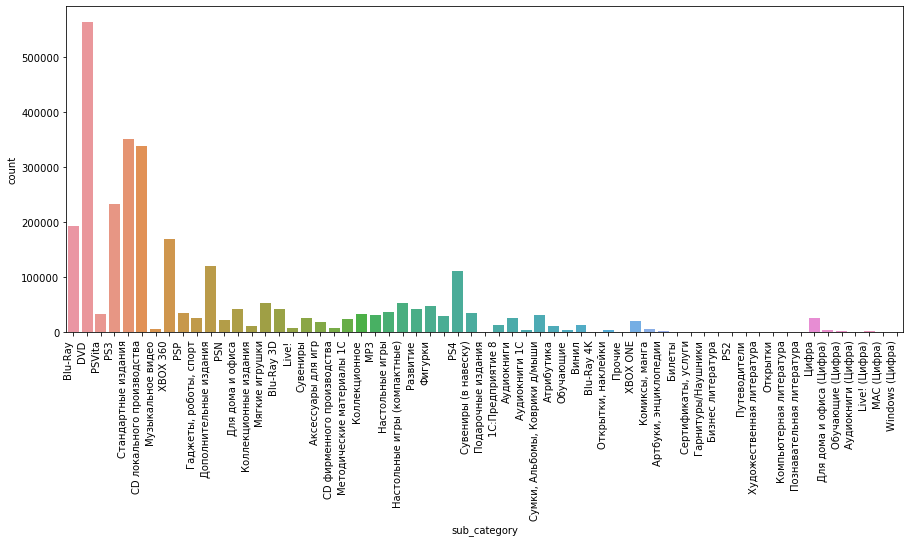

In [27]:
plt.figure(figsize=(15,6))
chart = sns.countplot(x='sub_category', data=train_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')

In [18]:
items['item_id'].nunique()

22170

#### Impute negative price value

In [408]:
train_df[train_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_name_correct,item_category_name,category,city,month,year
1158744,2013-05-15,4,32,2973,-1.0,1.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,"dmc devil may cry [ps3, русские субтитры]",Игры - PS3,Игры,Москва,5,2013


In [411]:
emply_values = train_df[(train_df.item_id == 2973) & (train_df.year== 2013) & (train_df.month == 5) & (train_df.city == 'Москва')]

In [413]:
item_price_to_impute = emply_values[emply_values.item_price > 0]['item_price'].mean()

In [415]:
train_df['item_price'] = train_df['item_price'].apply(lambda x: x if x > 0 else item_price_to_impute)

In [417]:
train_df[train_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_name_correct,item_category_name,category,city,month,year


In [33]:
train_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   date                2935849 non-null  object 
 1   date_block_num      2935849 non-null  int64  
 2   shop_id             2935849 non-null  int64  
 3   item_id             2935849 non-null  int64  
 4   item_price          2935849 non-null  float64
 5   item_cnt_day        2935849 non-null  float64
 6   shop_name           2935849 non-null  object 
 7   item_name           2935849 non-null  object 
 8   item_category_id    2935849 non-null  int64  
 9   item_category_name  2935849 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 310.9+ MB


In [34]:
test_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   ID                  214200 non-null  int64 
 1   shop_id             214200 non-null  int64 
 2   item_id             214200 non-null  int64 
 3   shop_name           214200 non-null  object
 4   item_name           214200 non-null  object
 5   item_category_id    214200 non-null  int64 
 6   item_category_name  214200 non-null  object
dtypes: int64(4), object(3)
memory usage: 13.1+ MB


In [20]:
items['item_name_correct'] = items['item_name'].apply(lambda x: x.lower())

In [21]:
items.head(20)

,item_name,item_id,item_category_id,item_name_correct
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! во власти наваждения (пласт.) d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,!abbyy finereader 12 professional edition full...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,***в лучах славы (unv) d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,***голубая волна (univ) d
4,***КОРОБКА (СТЕКЛО) D,4,40,***коробка (стекло) d
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,***новые американские граффити (uni) ...
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40,***удар по воротам (uni) d
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40,***удар по воротам-2 (uni) d
8,***ЧАЙ С МУССОЛИНИ D,8,40,***чай с муссолини d
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40,***шугарлэндский экспресс (uni) d


In [24]:
count_item = items['item_name_correct'].value_counts().reset_index()

In [30]:
duplicate_items = count_item[count_item.item_name_correct > 1]['index'].values

In [33]:
dupl = items[items.item_name_correct.isin(duplicate_items)]

In [52]:
dupl

,item_name,item_id,item_category_id,item_name_correct
8247,АЛЫЕ ПАРУСА (Регион),8247,40,алые паруса (регион)
8248,АЛЫЕ ПАРУСА (регион),8248,40,алые паруса (регион)
8289,АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),8289,40,английский вместе с хрюшей и… ч. 1 (регион)
8290,АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),8290,40,английский вместе с хрюшей и… ч. 1 (регион)
8298,АНДРЕЙ РУБЛЕВ (Регион),8298,40,андрей рублев (регион)
...,...,...,...,...
21850,ШЕРЛОК ХОЛМС И ДОКТОР ВАТСОН (регион),21850,40,шерлок холмс и доктор ватсон (регион)
21869,ШИРЛИ-МЫРЛИ (Регион),21869,40,ширли-мырли (регион)
21870,ШИРЛИ-МЫРЛИ (регион),21870,40,ширли-мырли (регион)
22023,ЭКИПАЖ (Регион),22023,40,экипаж (регион)


In [59]:
dupl.groupby('item_name_correct')['item_id'].apply(list).reset_index()['item_id'].values

array([list([8247, 8248]), list([8289, 8290]), list([8298, 8299]),
       list([8422, 8423]), list([8616, 8617]), list([8618, 8619]),
       list([8622, 8623]), list([8627, 8628]), list([8629, 8630]),
       list([8632, 8633]), list([8640, 8641]), list([8642, 8643]),
       list([8649, 8650]), list([8758, 8759]), list([8761, 8762]),
       list([8806, 8807]), list([9048, 9049]), list([9841, 9842]),
       list([9864, 9865]), list([10312, 10313]), list([10372, 10373]),
       list([10557, 10558]), list([10749, 10750]), list([10814, 10815]),
       list([10840, 10841]), list([10998, 10999]), list([11118, 11119]),
       list([11199, 11200]), list([11467, 11468]), list([11480, 11481]),
       list([11650, 11651]), list([11893, 11894]), list([12032, 12033]),
       list([12098, 12099]), list([12378, 12379]), list([14065, 14066]),
       list([14339, 14340]), list([14606, 14607]), list([14787, 14788]),
       list([15610, 15611]), list([16504, 16505]), list([16614, 16615]),
       list([172

In [36]:
dupl_ids = dupl['item_id'].values

In [45]:
sorted(test_df[test_df.item_id.isin(dupl_ids)]['item_id'].unique())

[8247, 9864, 10372, 10749, 10750, 11199, 11467, 12378, 18719, 18945, 19087]

In [53]:
train_df[train_df.item_id == 8289]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,category,city,month,year
716184,2013-11-23,10,25,8289,58.0,1.0,"Москва ТРК ""Атриум""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Москва,11,2013
716185,2013-12-10,11,25,8289,58.0,1.0,"Москва ТРК ""Атриум""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Москва,12,2013
716186,2013-02-05,1,23,8289,149.0,1.0,"Москва ТК ""Буденовский"" (пав.А2)",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Москва,2,2013
716187,2013-03-10,2,23,8289,149.0,1.0,"Москва ТК ""Буденовский"" (пав.А2)",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Москва,3,2013
716188,2013-11-21,10,19,8289,58.0,1.0,"Курск ТЦ ""Пушкинский""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Курск,11,2013
716189,2013-01-11,0,18,8289,149.0,1.0,"Красноярск ТЦ ""Июнь""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Красноярск,1,2013
716190,2013-10-12,9,28,8289,98.0,1.0,"Москва ТЦ ""МЕГА Теплый Стан"" II",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Москва,10,2013
716191,2013-09-18,8,29,8289,98.0,1.0,"Москва ТЦ ""Новый век"" (Новокосино)",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Москва,9,2013
716192,2013-11-15,10,29,8289,58.0,1.0,"Москва ТЦ ""Новый век"" (Новокосино)",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Москва,11,2013
716193,2013-10-03,9,4,8289,98.0,1.0,"Волжский ТЦ ""Волга Молл""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),40,Кино - DVD,Кино,Волжский,10,2013


In [54]:
train_df[train_df.item_id == 8290]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,category,city,month,year
690745,2013-04-28,3,25,8290,149.0,1.0,"Москва ТРК ""Атриум""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Москва,4,2013
690746,2013-06-29,5,25,8290,149.0,1.0,"Москва ТРК ""Атриум""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Москва,6,2013
690747,2013-08-26,7,25,8290,149.0,1.0,"Москва ТРК ""Атриум""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Москва,8,2013
690748,2013-09-29,8,25,8290,149.0,1.0,"Москва ТРК ""Атриум""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Москва,9,2013
690749,2013-02-03,1,24,8290,149.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Москва,2,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690812,2014-01-04,12,44,8290,149.0,1.0,"Самара ТЦ ""Мелодия""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Самара,1,2014
690813,2013-05-24,4,46,8290,149.0,1.0,"Сергиев Посад ТЦ ""7Я""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Сергиев,5,2013
690814,2013-08-25,7,46,8290,149.0,1.0,"Сергиев Посад ТЦ ""7Я""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Сергиев,8,2013
690815,2013-10-08,9,46,8290,149.0,1.0,"Сергиев Посад ТЦ ""7Я""",АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),40,Кино - DVD,Кино,Сергиев,10,2013


#### Fill the missing values

In [533]:
all_dates = pd.date_range(start='2013-01-01', end='2015-10-31', freq='MS')
all_dates_df = pd.DataFrame({'date':all_dates})
item_dates = items.merge(all_dates_df, how='cross')[['item_id', 'date']]

In [543]:
item_ids = items[[ 'item_id']].drop_duplicates()

In [544]:
item_id_dataset = item_ids.merge(all_dates_df, how='cross')
item_id_dataset['month'] = item_id_dataset['date'].apply(lambda x: x.month) 
item_id_dataset['year'] = item_id_dataset['date'].apply(lambda x: x.year) 
item_id_dataset = item_id_dataset.drop(columns = ['date'])

In [545]:
item_id_dataset.head()

,item_id,month,year
0,0,1,2013
1,0,2,2013
2,0,3,2013
3,0,4,2013
4,0,5,2013


## EDA

In [147]:
train_df.groupby(['shop_name']).agg({'date': ('min', 'max')})

date           
                                                       min        max
shop_name                                                            
Адыгея ТЦ "Мега"                                2013-01-01 2015-10-31
Балашиха ТРК "Октябрь-Киномир"                  2013-01-02 2015-10-31
Волжский ТЦ "Волга Молл"                        2013-01-02 2015-10-31
Вологда ТРЦ "Мармелад"                          2013-02-08 2015-10-31
Воронеж (Плехановская, 13)                      2013-01-02 2015-10-31
Воронеж ТРЦ "Максимир"                          2013-01-01 2015-10-31
Воронеж ТРЦ Сити-Парк "Град"                    2013-01-01 2013-04-01
Выездная Торговля                               2013-10-03 2015-10-14
Жуковский ул. Чкалова 39м²                      2013-01-02 2015-10-31
Интернет-магазин ЧС                             2013-01-03 2015-10-30
Казань ТЦ "Бехетле"                             2013-01-01 2014-08-09
Казань ТЦ "ПаркХаус" II                         2013-01-01 2015-10-31
Калуга ТРЦ "XXI век"                            2013-01-01 2015-10-31
Коломна ТЦ "Рио"                                2013-01-02 2015-10-31
Красноярск ТЦ "Взлетка Плаза"                   2013-06-06 2015-01-18
Красноярск ТЦ "Июнь"                            2013-01-01 2015-10-31
Курск ТЦ "Пушкинский"                           2013-01-01 2015-10-31
Москва "Распродажа"                             2014-10-02 2015-10-04
Москва МТРЦ "Афи Молл"                          2013-01-02 2015-10-31
Москва Магазин С21                              2013-01-02 2015-10-31
Москва ТК "Буденовский" (пав.А2)                2013-01-02 2013-04-28
Москва ТК "Буденовский" (пав.К7)                2013-01-02 2015-10-31
Москва ТРК "Атриум"                             2013-01-02 2015-10-31
Москва ТЦ "Ареал" (Беляево)                     2013-01-02 2015-10-31
Москва ТЦ "МЕГА Белая Дача II"                  2013-01-01 2015-09-30
Москва ТЦ "МЕГА Теплый Стан" II                 2013-01-01 2015-10-31
Москва ТЦ "Новый век" (Новокосино)              2013-01-02 2015-05-28
Москва ТЦ "Перловский"                          2013-01-02 2015-02-18
Москва ТЦ "Семеновский"                         2013-01-02 2015-10-31
Москва ТЦ "Серебряный Дом"                      2013-01-02 2013-07-03
Мытищи ТРК "XL-3"                               2014-08-29 2015-04-24
Н.Новгород ТРЦ "РИО"                            2014-07-31 2015-10-31
Н.Новгород ТРЦ "Фантастика"                     2013-01-02 2015-10-31
Новосибирск ТРЦ "Галерея Новосибирск"           2015-10-18 2015-10-31
Новосибирск ТЦ "Мега"                           2013-01-01 2015-10-31
Омск ТЦ "Мега"                                  2013-01-01 2015-10-31
РостовНаДону ТРК "Мегацентр Горизонт"           2014-03-01 2015-10-31
РостовНаДону ТРК "Мегацентр Горизонт" Островной 2014-03-01 2015-01-29
РостовНаДону ТЦ "Мега"                          2013-01-01 2015-10-31
СПб ТК "Невский Центр"                          2013-01-01 2015-10-31
СПб ТК "Сенная"                                 2013-01-03 2015-01-25
Самара ТЦ "Мелодия"                             2013-01-02 2015-10-31
Самара ТЦ "ПаркХаус"                            2013-01-02 2015-10-31
Сергиев Посад ТЦ "7Я"                           2013-01-01 2015-10-31
Сургут ТРЦ "Сити Молл"                          2013-01-02 2015-10-31
Томск ТРЦ "Изумрудный Город"                    2014-04-25 2015-10-31
Тюмень ТРЦ "Кристалл"                           2013-12-25 2015-10-31
Тюмень ТЦ "Гудвин"                              2013-01-02 2015-10-31
Тюмень ТЦ "Зеленый Берег"                       2013-01-01 2015-09-28
Уфа ТК "Центральный"                            2013-01-02 2015-10-31
Уфа ТЦ "Семья" 2                                2013-01-02 2015-10-31
Химки ТЦ "Мега"                                 2013-01-01 2015-04-23
Цифровой склад 1С-Онлайн                        2013-05-01 2015-10-31
Чехов ТРЦ "Карнавал"                            2013-01-02 2015-10-31
Якутск Орджоникидзе, 56                         2013-01-03 2015-

In [148]:
train_df.groupby(['item_category_name']).agg({'date': ('min', 'max')})

date           
                                 min        max
item_category_name                             
PC - Гарнитуры/Наушники   2013-01-10 2013-04-02
Аксессуары - PS2          2013-01-10 2013-02-20
Аксессуары - PS3          2013-01-01 2015-10-30
Аксессуары - PS4          2013-01-01 2015-10-31
Аксессуары - PSP          2013-01-01 2015-08-13
...                              ...        ...
Служебные                 2013-01-01 2015-10-31
Служебные - Билеты        2015-04-27 2015-09-30
Чистые носители (шпиль)   2013-01-01 2015-03-26
Чистые носители (штучные) 2013-01-01 2015-01-23
Элементы питания          2013-01-01 2015-10-31

[84 rows x 2 columns]

In [563]:
train_df['item_cnt_day'].min(), train_df['item_cnt_day'].max()

(0.0, 2169.0)

In [52]:
train_df[train_df['item_cnt_day'] == 2169]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2900512,28.10.2015,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара


In [77]:
train_by_month = train_df.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()

### Total sales by train time

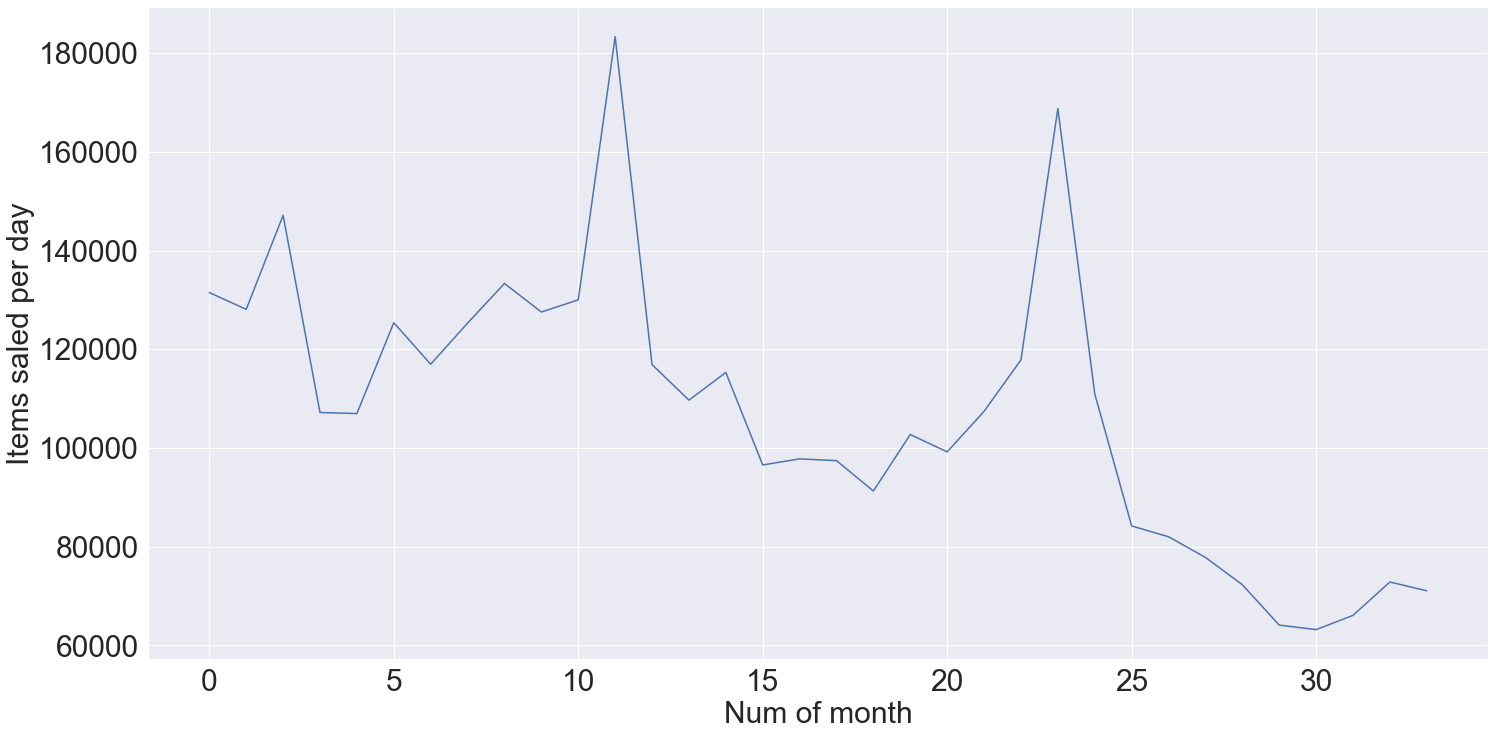

In [564]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel('Num of month', fontsize=30)
plt.ylabel('Items saled per day', fontsize=30)
plt.plot(train_by_month['date_block_num'], train_by_month['item_cnt_day'])

### Train by month year

In [565]:
def get_month_year_graph(df, title='', ax=None):
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    if not ax:
        fig, (ax1) = plt.subplots(1, 1)
        axis = ax1
    else:    
        axis = ax
    month_year_data = df.groupby(['month', 'year']).agg({'item_cnt_day': 'sum'}).reset_index()
    month_year_data['year_month'] = month_year_data.apply(lambda x: f"{int(x['month'])}-{int(x['year'])}", axis=1 )
    month_year_data = month_year_data.sort_values(by=['year', 'month'])
    axis.set_xticklabels(month_year_data['year_month'], rotation=90)
    axis.set_xlabel('Year-month', fontsize=20)
    axis.set_ylabel('Items saled per Year-month', fontsize=20)
    axis.set_title(title, fontsize=30)
    axis.plot(month_year_data['year_month'], month_year_data['item_cnt_day'])

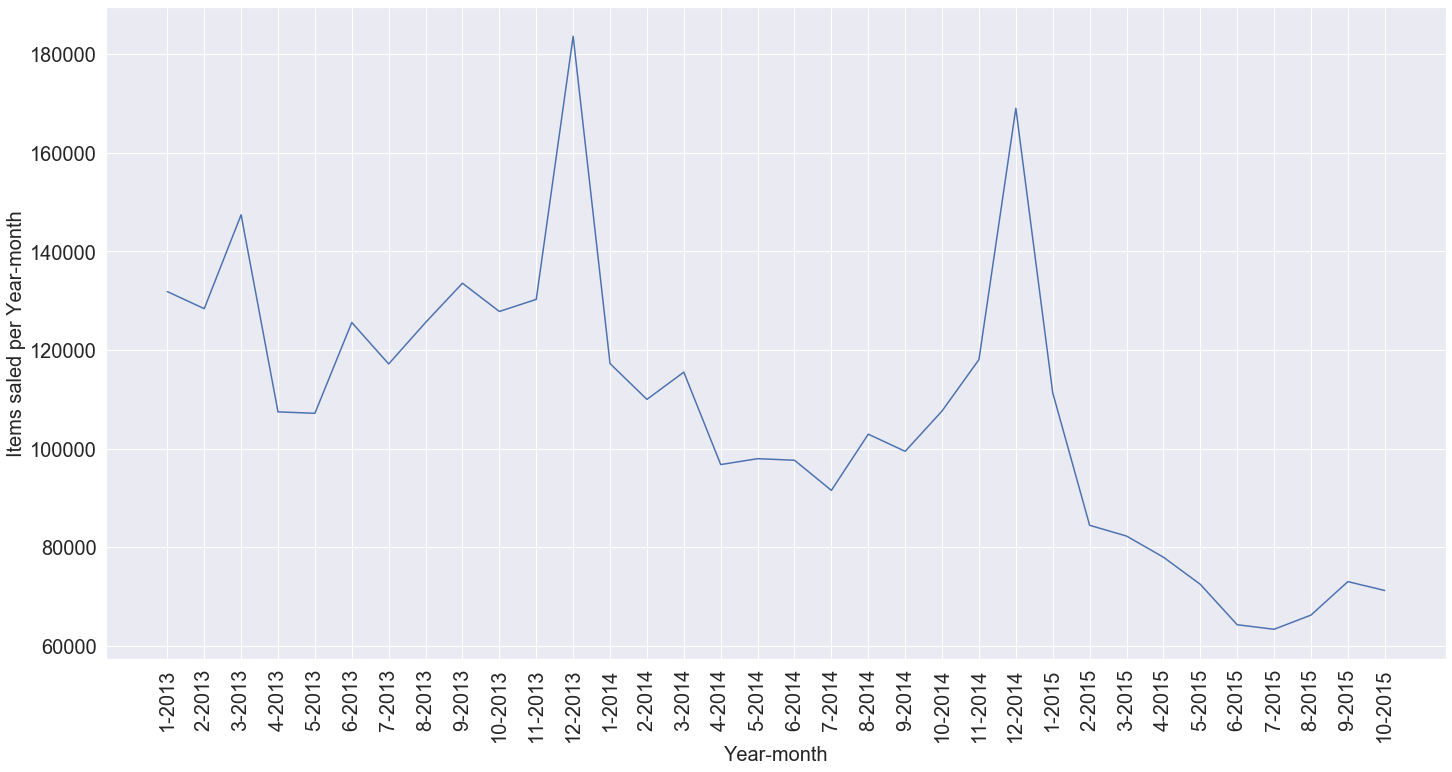

In [566]:
get_month_year_graph(train_df)

###  Category sales by month

In [567]:
category_grouped_info = train_df.groupby(['month', 'year', 'category']).agg({'item_cnt_day': 'sum'}).reset_index()

In [568]:
categories = category_grouped_info['category'].unique()

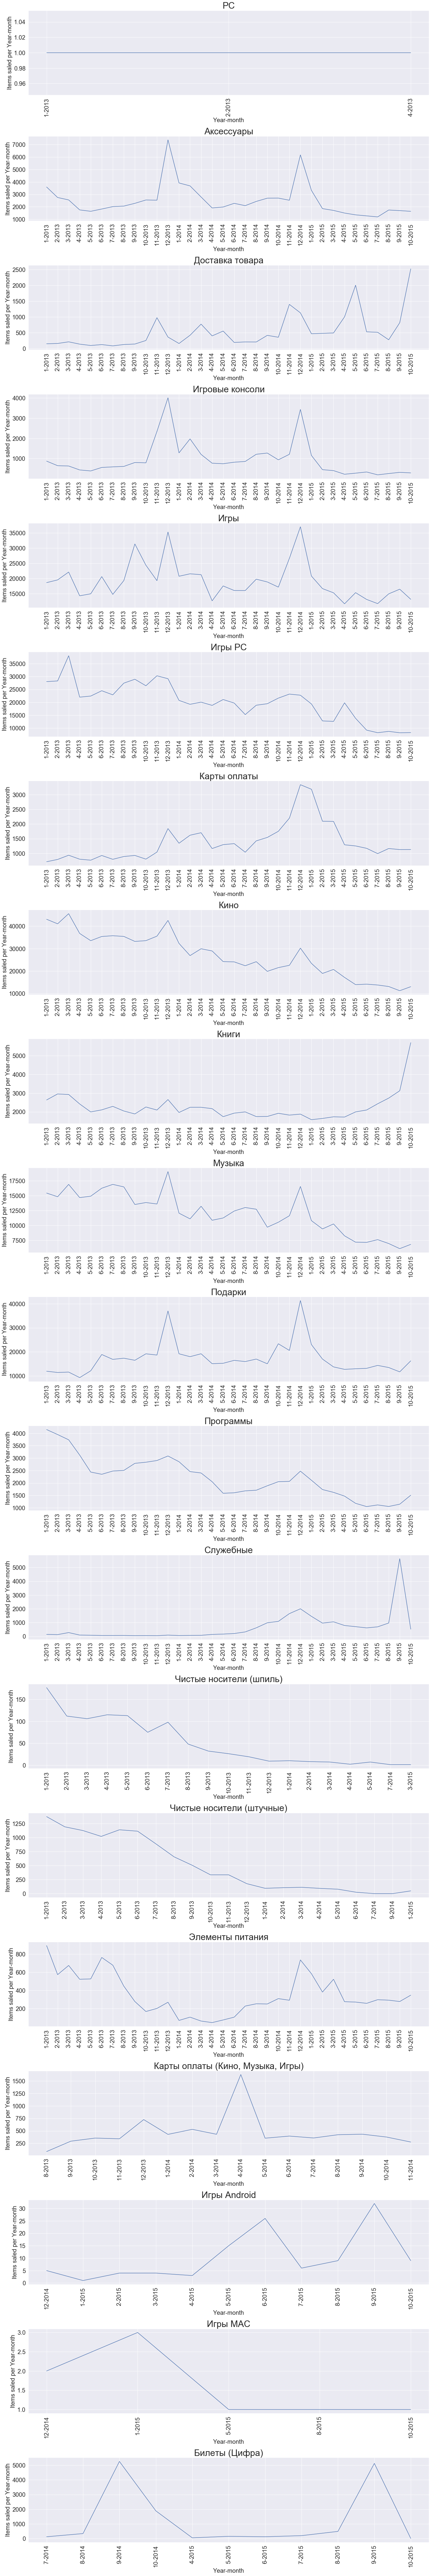

In [569]:
fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(20, 120), constrained_layout=True)
for ind, c in enumerate(categories):
    chart_ax = axes[ind]
    cat_info = category_grouped_info[category_grouped_info.category == c]
    get_month_year_graph(cat_info, title=c, ax=chart_ax)

In [294]:
items

,item_name,item_id,item_category_id,item_name_correct
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! во власти наваждения (пласт.) d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,!abbyy finereader 12 professional edition full...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,***в лучах славы (unv) d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,***голубая волна (univ) d
4,***КОРОБКА (СТЕКЛО) D,4,40,***коробка (стекло) d
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,"ядерный титбит 2 [pc, цифровая версия]"
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,язык запросов 1с:предприятия [цифровая версия]
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,язык запросов 1с:предприятия 8 (+cd). хрустале...
22168,Яйцо для Little Inu,22168,62,яйцо для little inu


### Num of active shops per month

In [71]:
shops_per_month = train_df.groupby(['date_block_num'])['shop_id'].nunique()

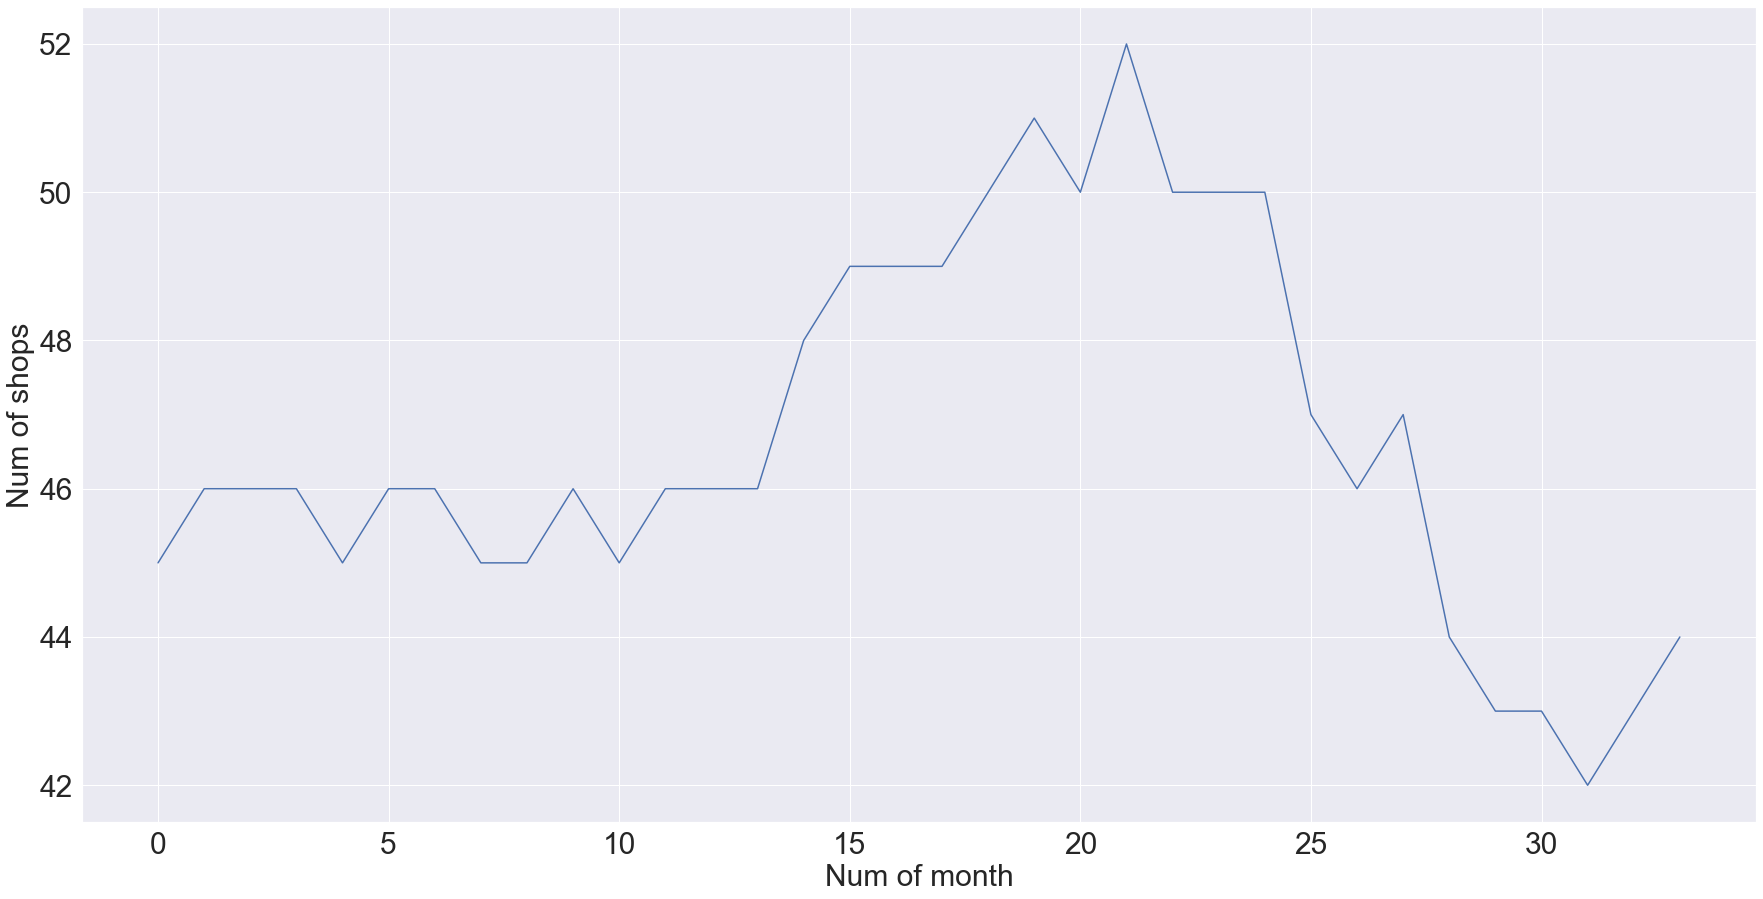

In [75]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel('Num of month', fontsize=30)
plt.ylabel('Num of shops', fontsize=30)
plt.plot(train_by_month['date_block_num'], shops_per_month.values)

### Num of saled item ids per month

In [83]:
items_per_month = train_df.groupby(['date_block_num'])['item_id'].nunique()

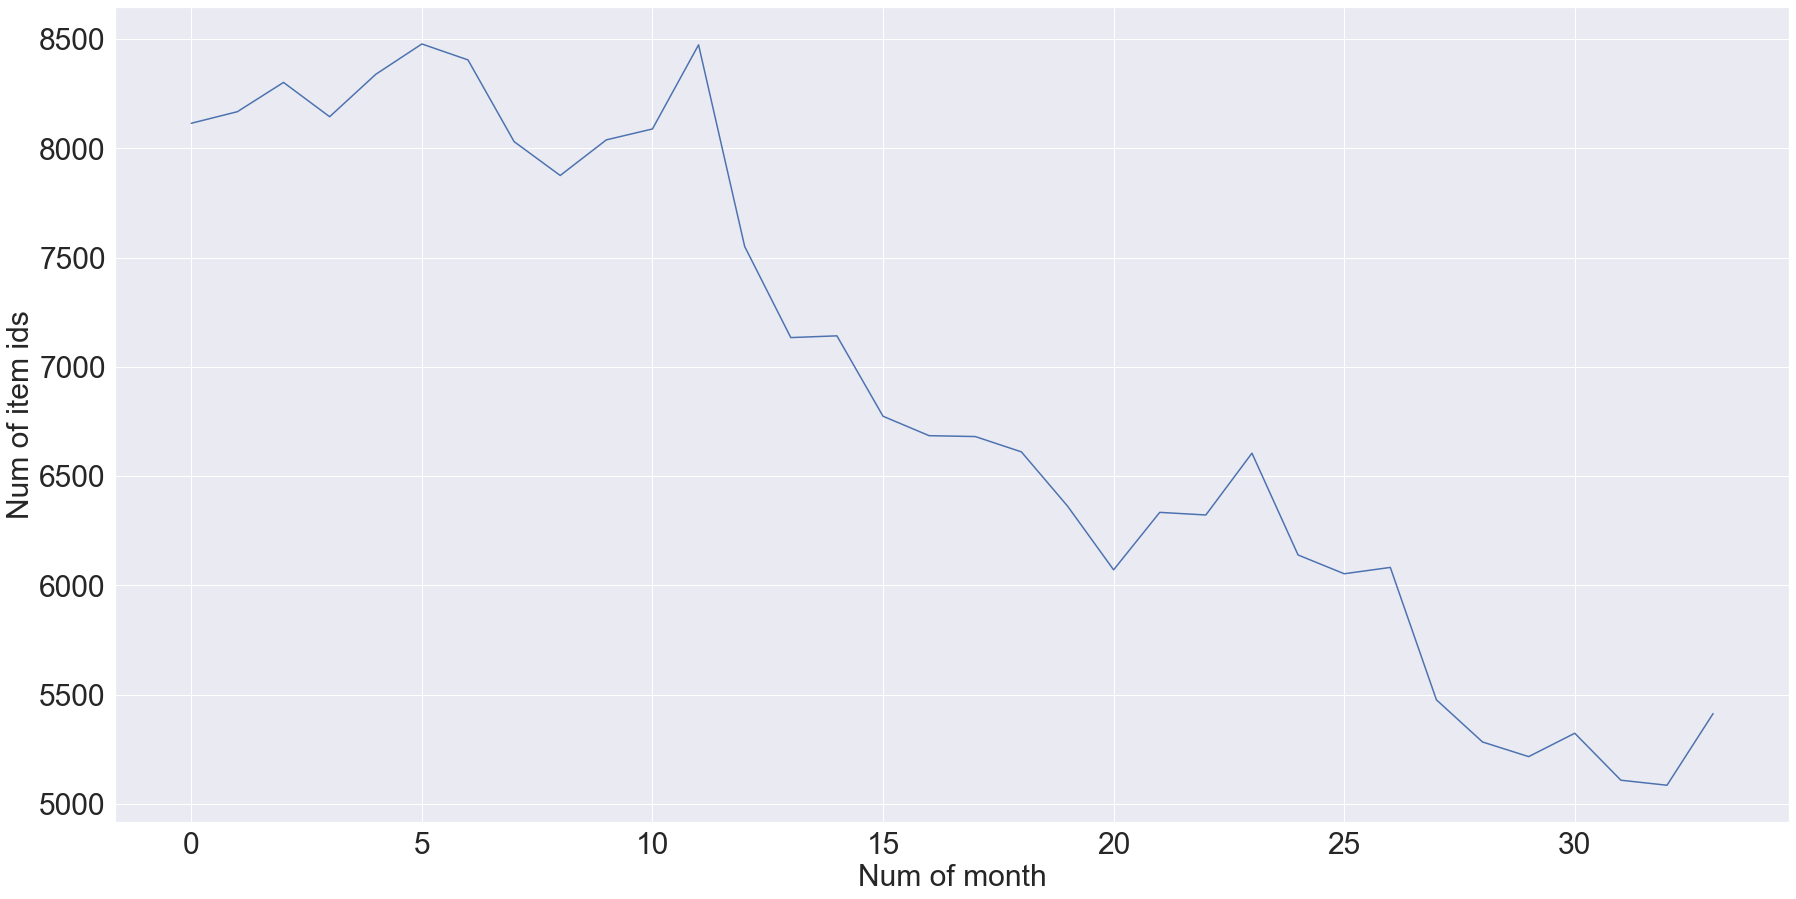

In [85]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel('Num of month', fontsize=30)
plt.ylabel('Num of item ids', fontsize=30)
plt.plot(train_by_month['date_block_num'], items_per_month.values)

### New items and new shops per month

In [419]:
item_start_date = train_df.groupby('item_id').agg({'date':'min'}).reset_index()
shop_start_date = train_df.groupby('shop_id').agg({'date':'min'}).reset_index()

In [428]:
shop_start_date['month'] = shop_start_date.date.apply(lambda x: x.month)
shop_start_date['year'] = shop_start_date.date.apply(lambda x: x.year)
shop_start_date['year_month'] = shop_start_date.date.apply(lambda x: f'{x.year}-{x.month}')

item_start_date['month'] = item_start_date.date.apply(lambda x: x.month)
item_start_date['year'] = item_start_date.date.apply(lambda x: x.year)
item_start_date['year_month'] = item_start_date.date.apply(lambda x: f'{x.year}-{x.month}')

#### Shop start moment

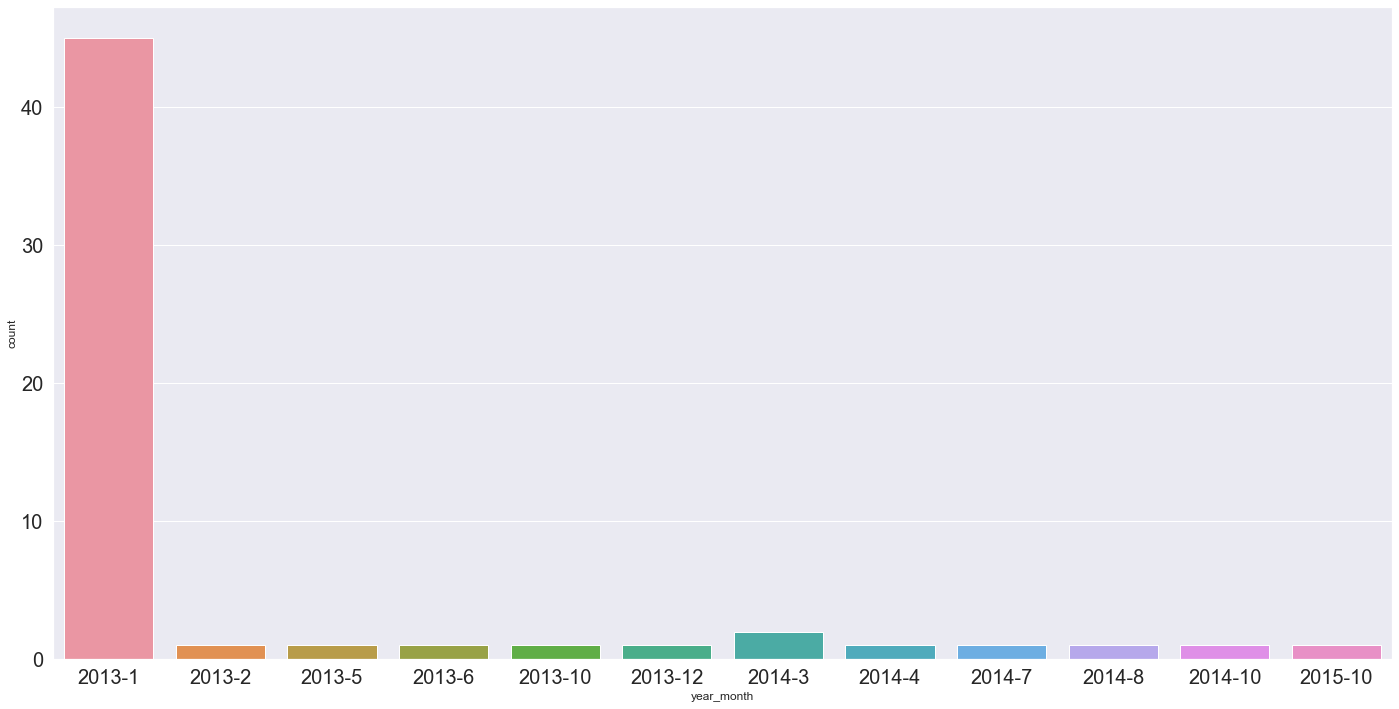

In [434]:
sns.countplot(x='year_month', data=shop_start_date, order=shop_start_date.sort_values(by=['year', 'month'])['year_month'].unique())

[Text(0, 0, '2013-1'),
 Text(0, 0, '2013-2'),
 Text(0, 0, '2013-3'),
 Text(0, 0, '2013-4'),
 Text(0, 0, '2013-5'),
 Text(0, 0, '2013-6'),
 Text(0, 0, '2013-7'),
 Text(0, 0, '2013-8'),
 Text(0, 0, '2013-9'),
 Text(0, 0, '2013-10'),
 Text(0, 0, '2013-11'),
 Text(0, 0, '2013-12'),
 Text(0, 0, '2014-1'),
 Text(0, 0, '2014-2'),
 Text(0, 0, '2014-3'),
 Text(0, 0, '2014-4'),
 Text(0, 0, '2014-5'),
 Text(0, 0, '2014-6'),
 Text(0, 0, '2014-7'),
 Text(0, 0, '2014-8'),
 Text(0, 0, '2014-9'),
 Text(0, 0, '2014-10'),
 Text(0, 0, '2014-11'),
 Text(0, 0, '2014-12'),
 Text(0, 0, '2015-1'),
 Text(0, 0, '2015-2'),
 Text(0, 0, '2015-3'),
 Text(0, 0, '2015-4'),
 Text(0, 0, '2015-5'),
 Text(0, 0, '2015-6'),
 Text(0, 0, '2015-7'),
 Text(0, 0, '2015-8'),
 Text(0, 0, '2015-9'),
 Text(0, 0, '2015-10')]

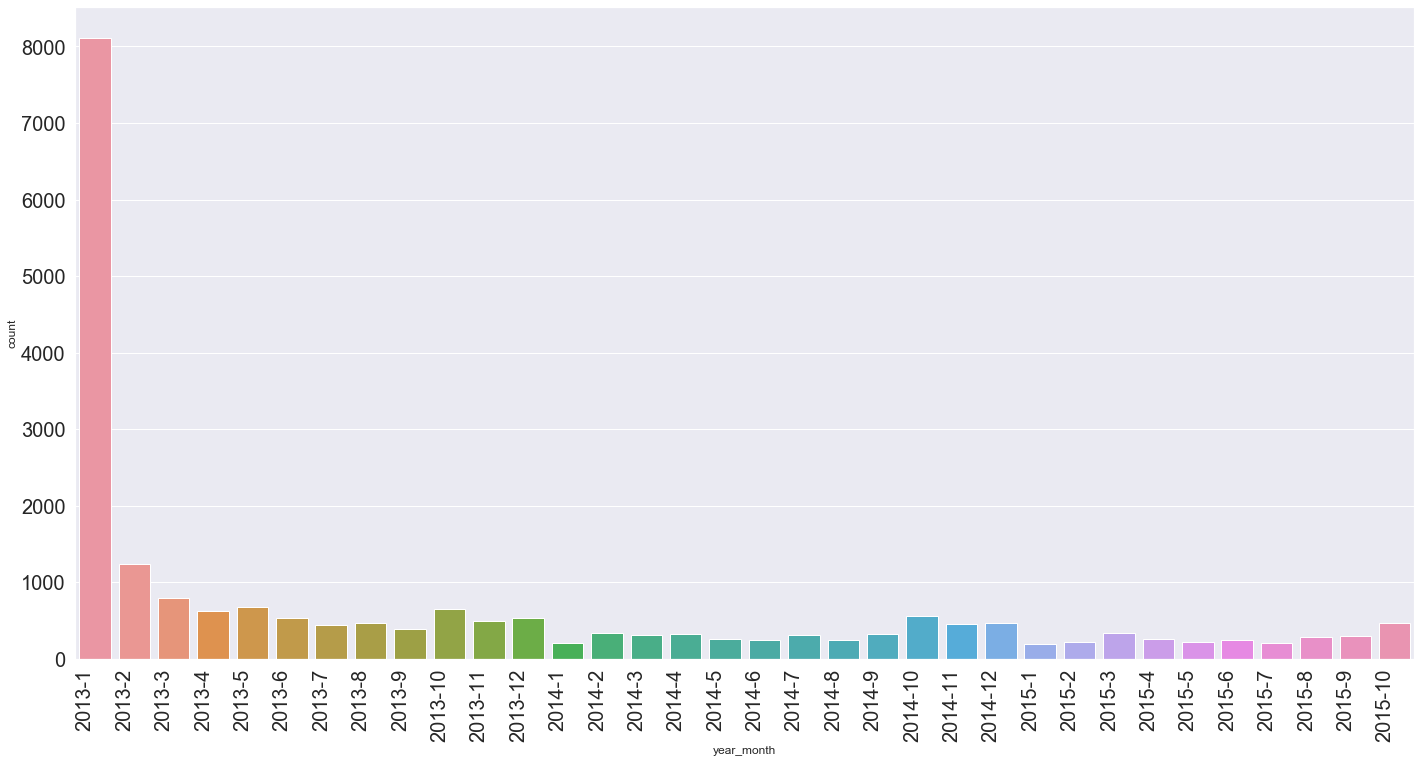

In [438]:
chart = sns.countplot(x='year_month', data=item_start_date, order=item_start_date.sort_values(by=['year', 'month'])['year_month'].unique())
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')

### Profit per month

In [87]:
train_df['day_profit'] = train_df.apply(lambda x: x['item_price']*x['item_cnt_day'], axis=1)

In [90]:
profit_per_month = train_df.groupby(['date_block_num']).agg({'day_profit':'sum'})

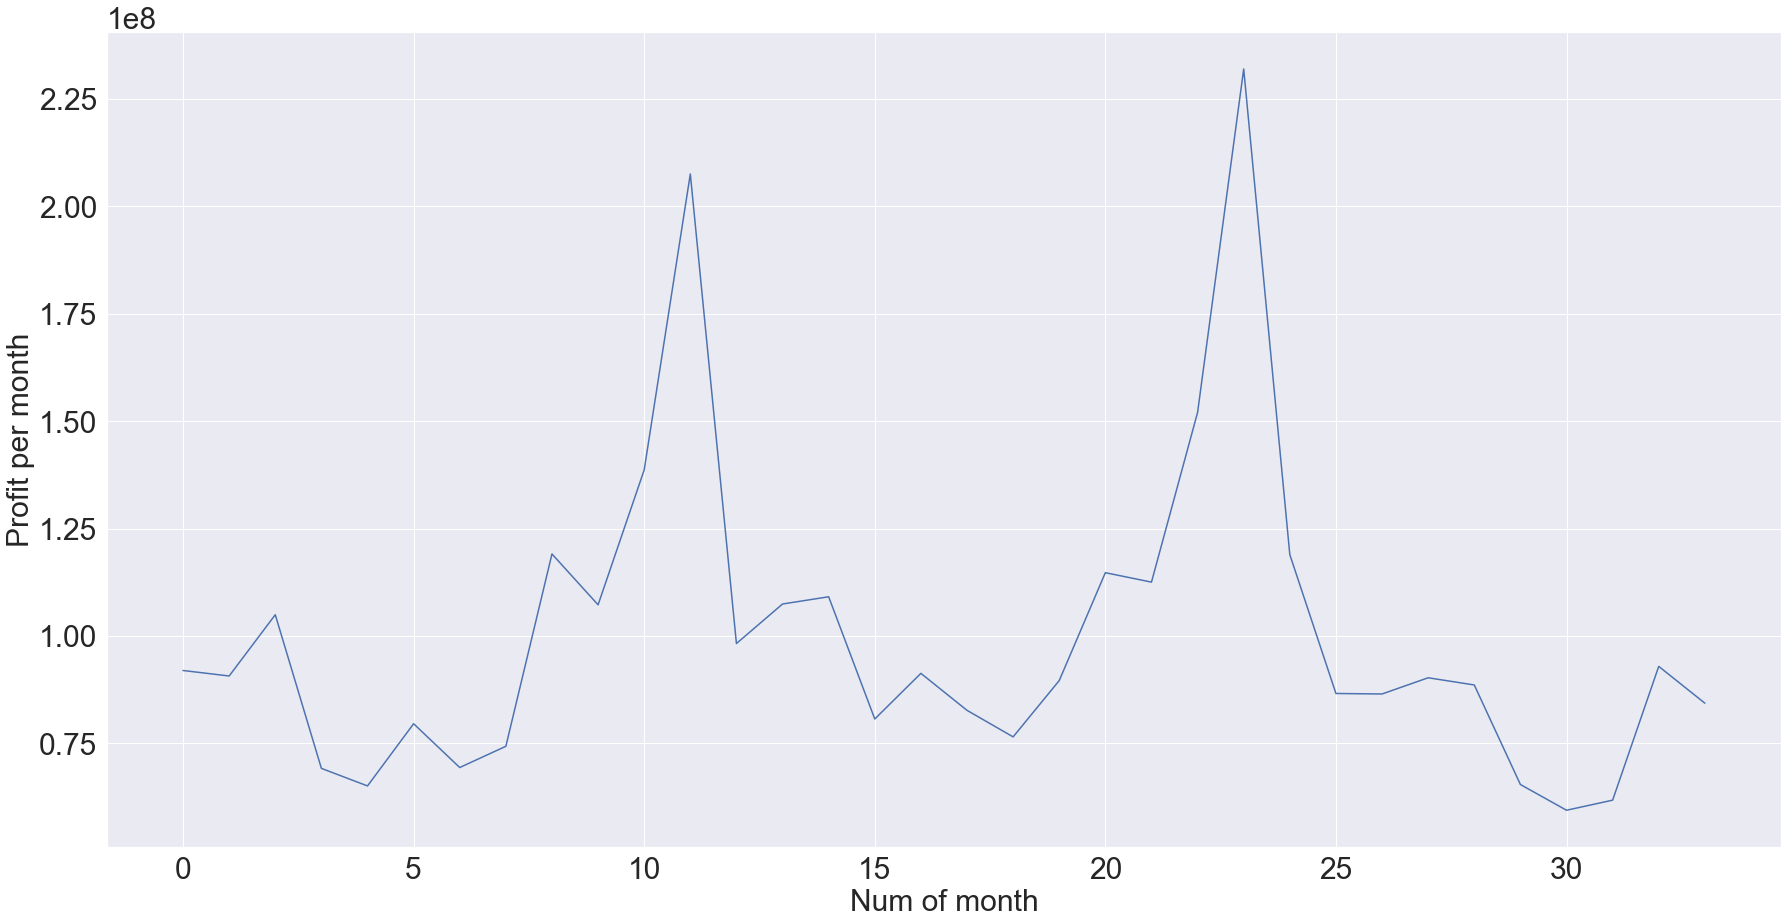

In [92]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel('Num of month', fontsize=30)
plt.ylabel('Profit per month', fontsize=30)
plt.plot(train_by_month['date_block_num'], profit_per_month.values)

### Category distribution

#### Train

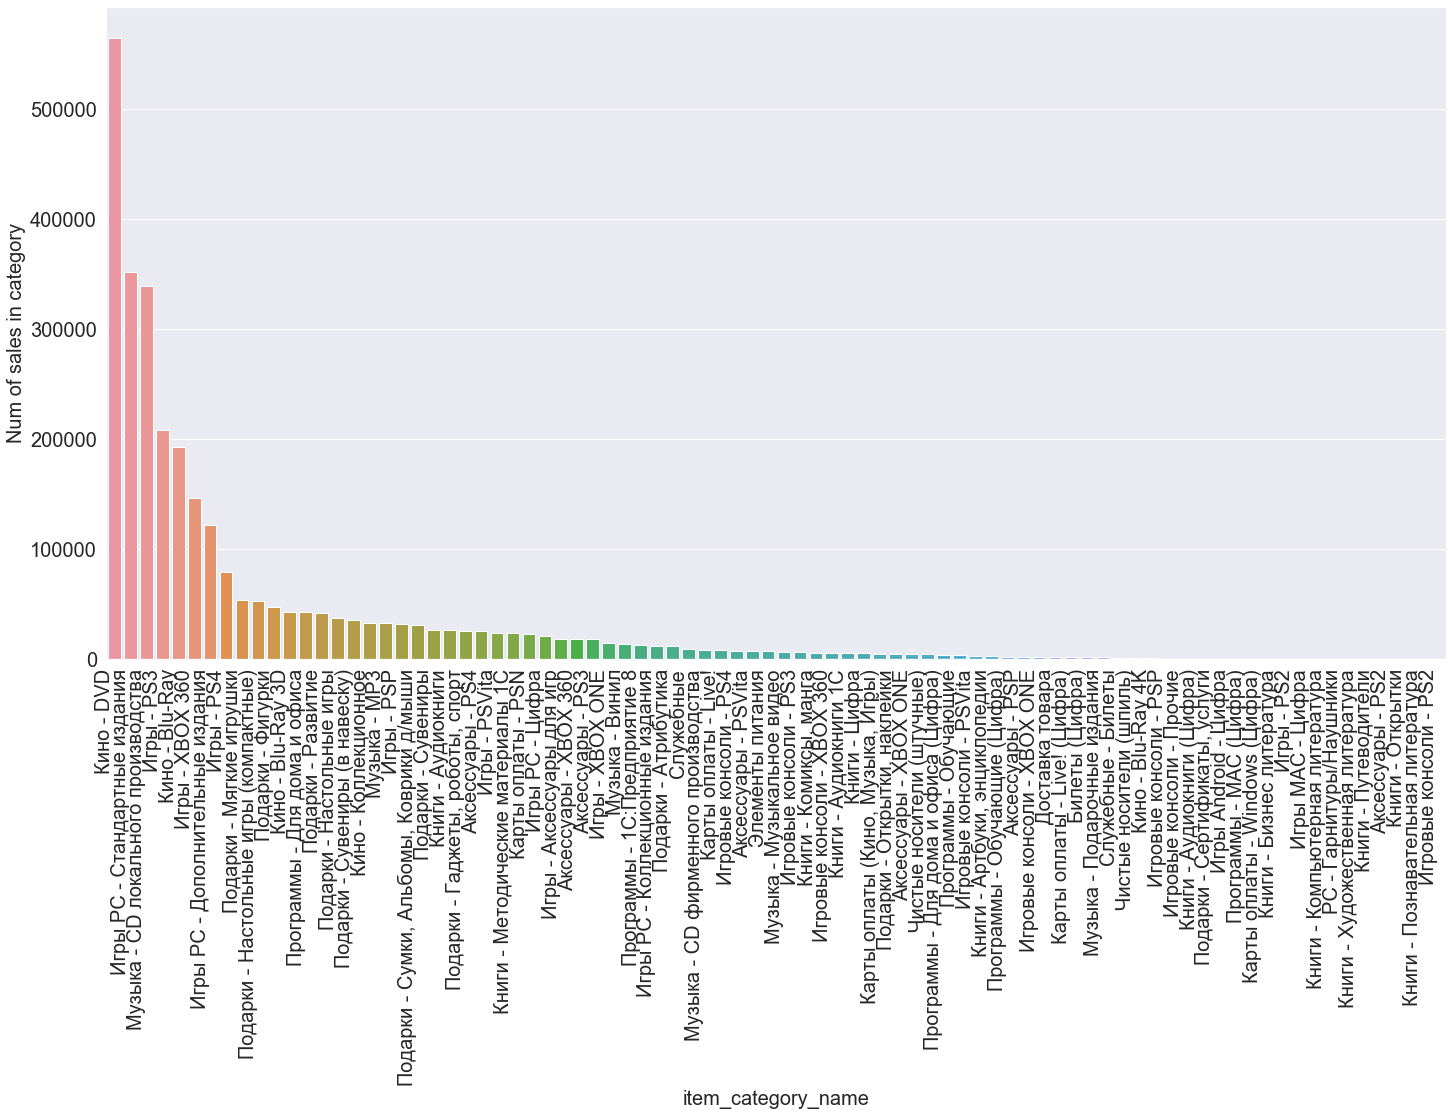

In [96]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(train_df['item_category_name'], order = train_df['item_category_name'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=30)
plt.xlabel('item_category_name', fontsize=20);
plt.ylabel('Num of sales in category', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

#### Test

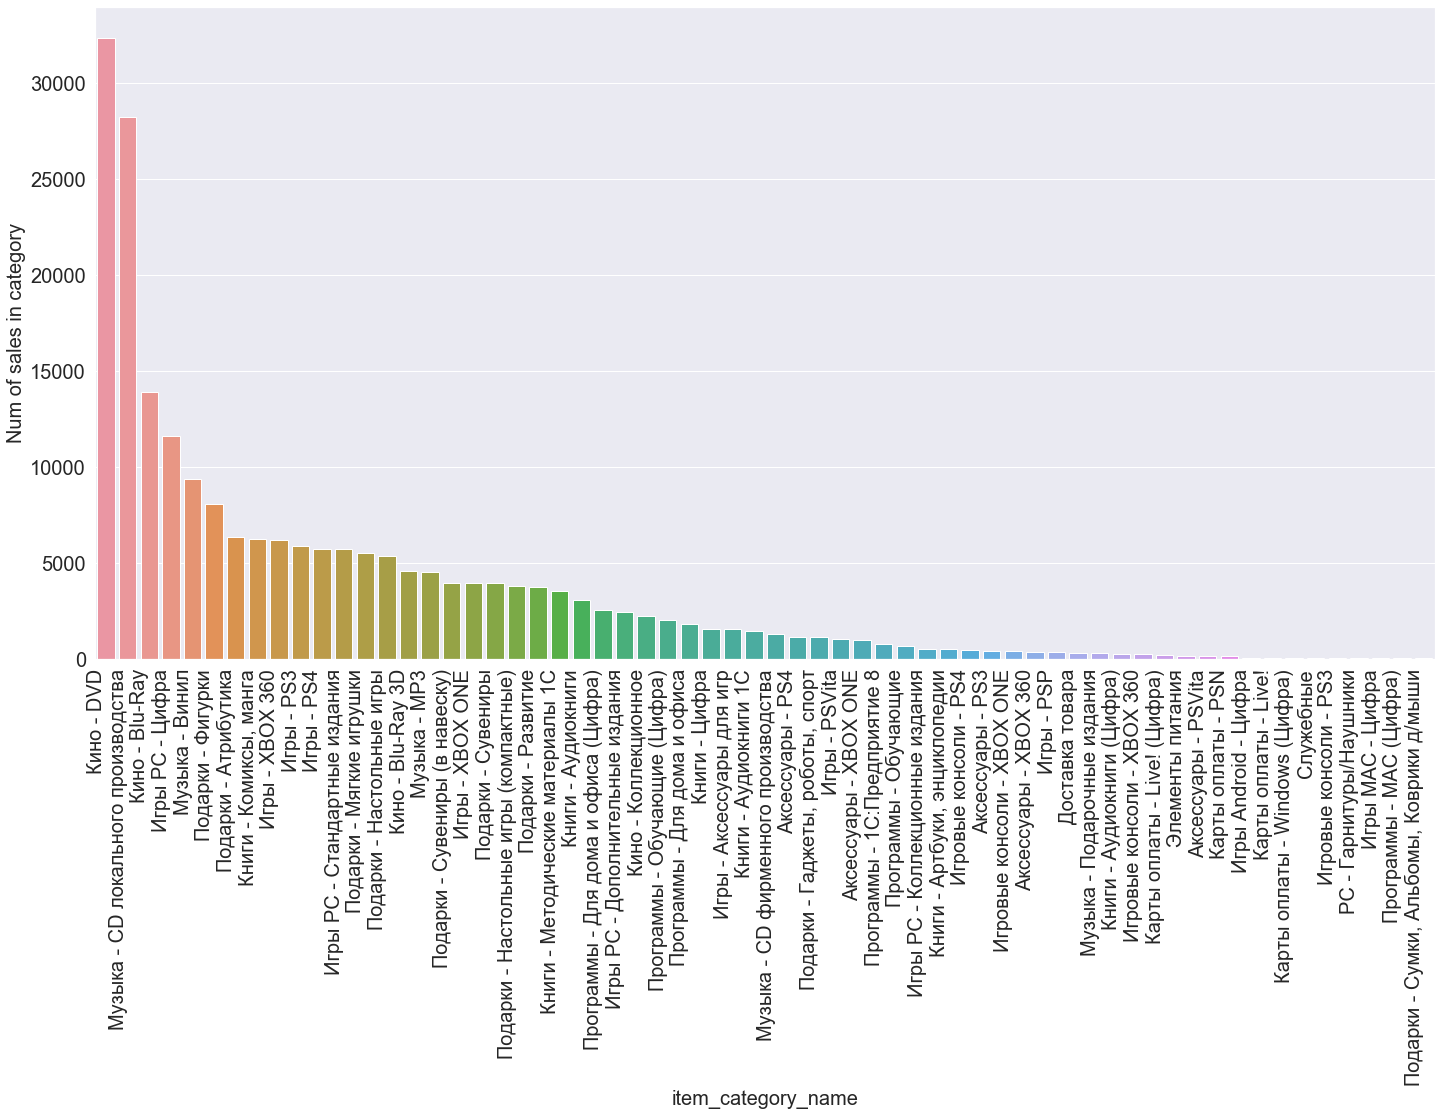

In [97]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(test_df['item_category_name'], order = test_df['item_category_name'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=30)
plt.xlabel('item_category_name', fontsize=20);
plt.ylabel('Num of sales in category', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

### Global category distribution

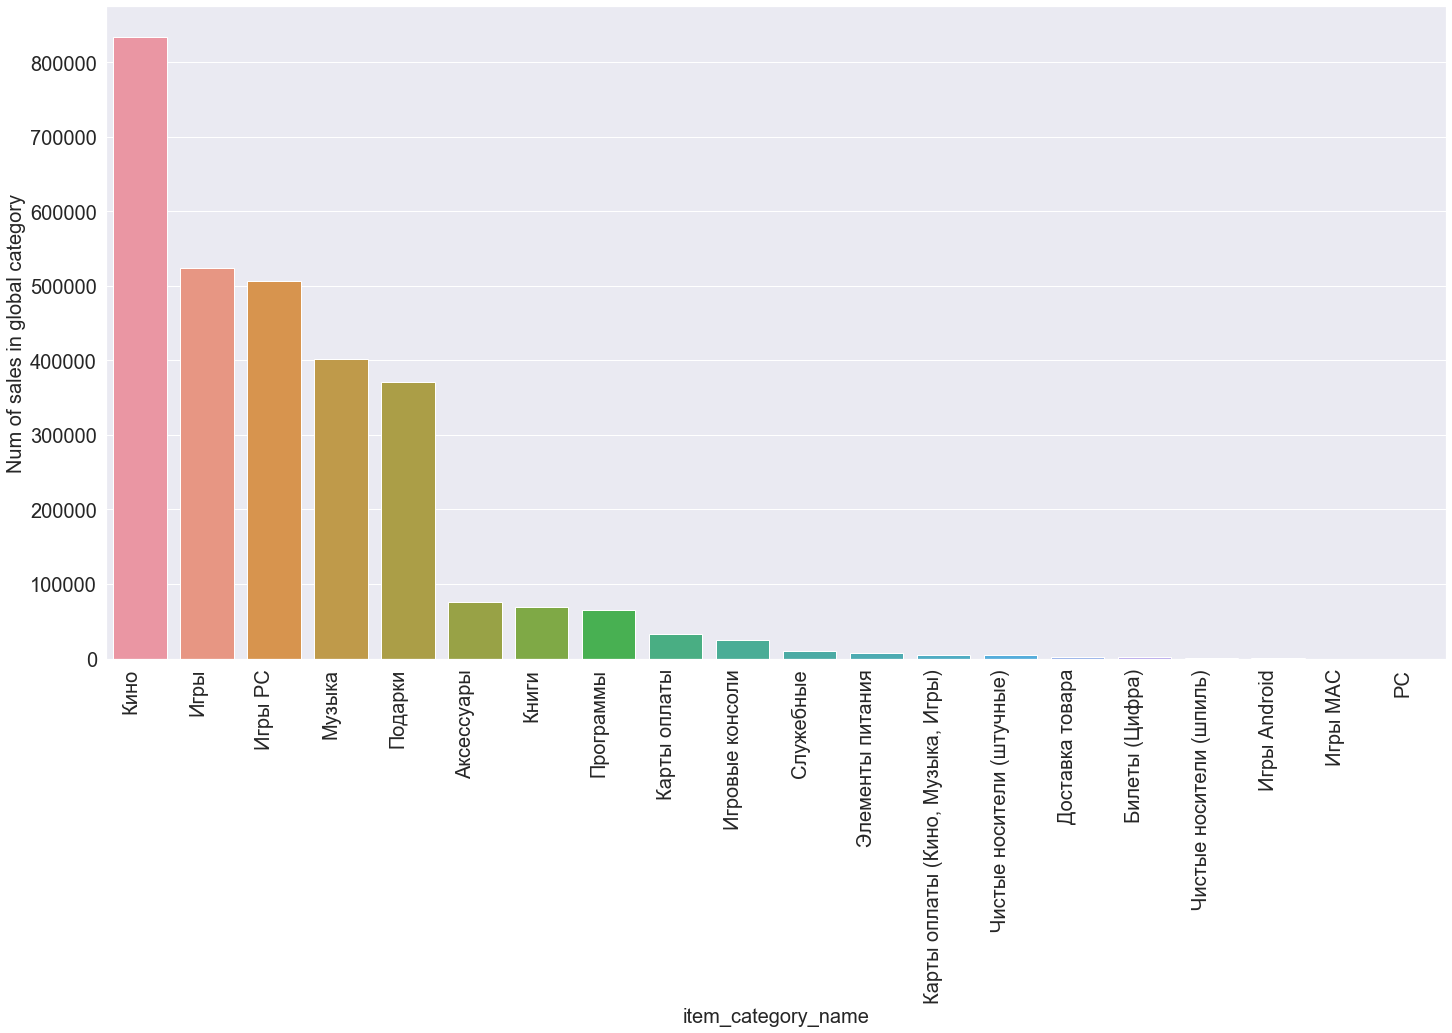

In [152]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(train_df['category'], order = train_df['category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=30)
plt.xlabel('item_category_name', fontsize=20);
plt.ylabel('Num of sales in global category', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

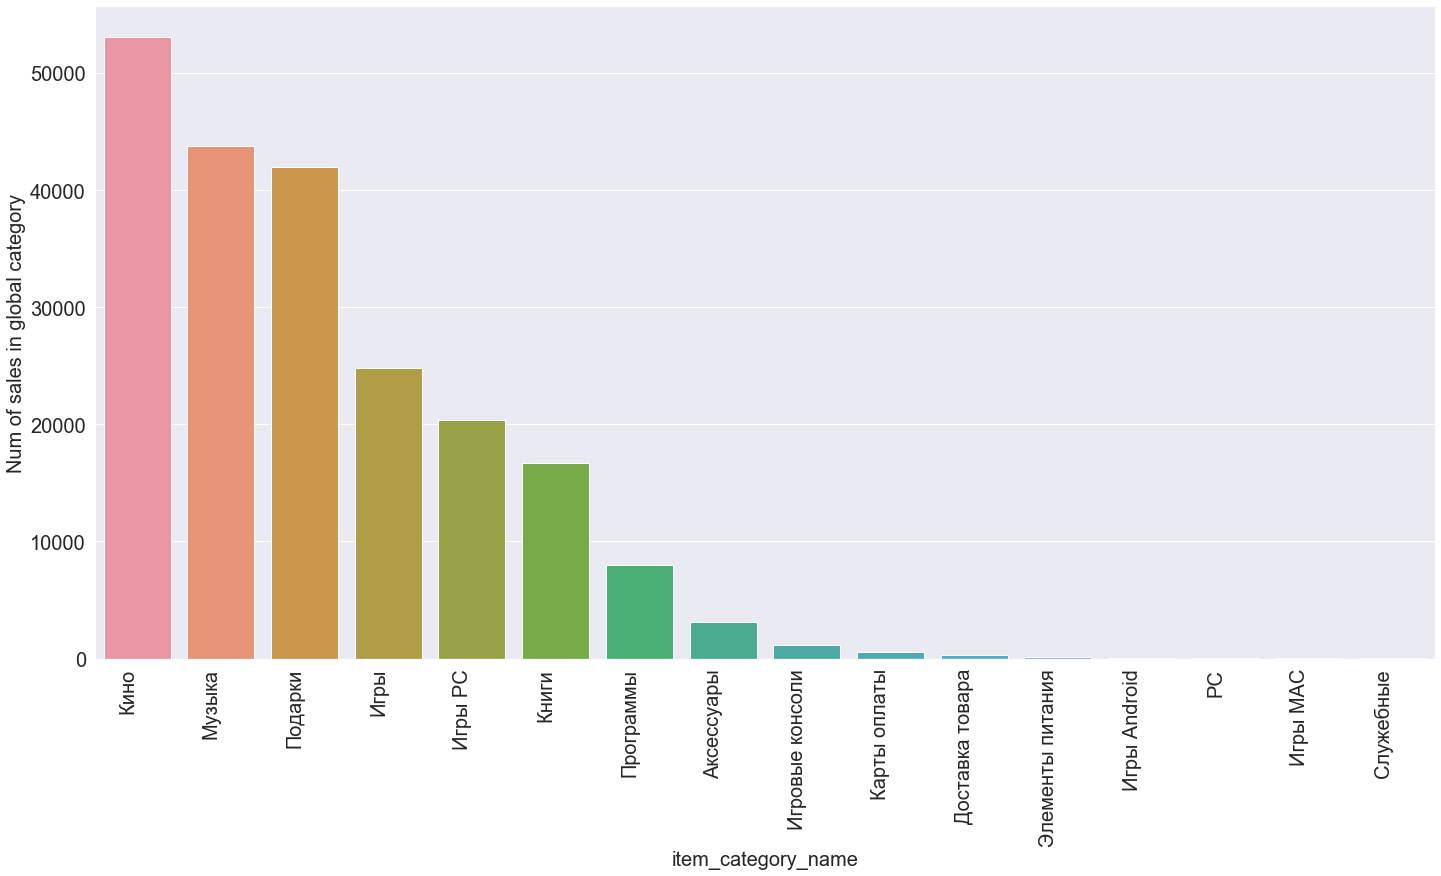

In [153]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(test_df['category'], order = test_df['category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=30)
plt.xlabel('item_category_name', fontsize=20);
plt.ylabel('Num of sales in global category', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

### Items price distribution

In [100]:
train_df['item_price'].describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [105]:
train_df[train_df.item_price < 300000]['item_price'].describe()

count    2.935848e+06
mean     8.907486e+02
std      1.720490e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      5.920000e+04
Name: item_price, dtype: float64

In [103]:
train_df[train_df.item_price == train_df['item_price'].min()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,day_profit
1158718,15.05.2013,4,32,2973,-1.0,1.0,"Москва ТЦ ""Серебряный Дом""","DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,-1.0


In [104]:
train_df[train_df.item_price == train_df['item_price'].max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,day_profit
2105022,13.12.2013,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,307980.0


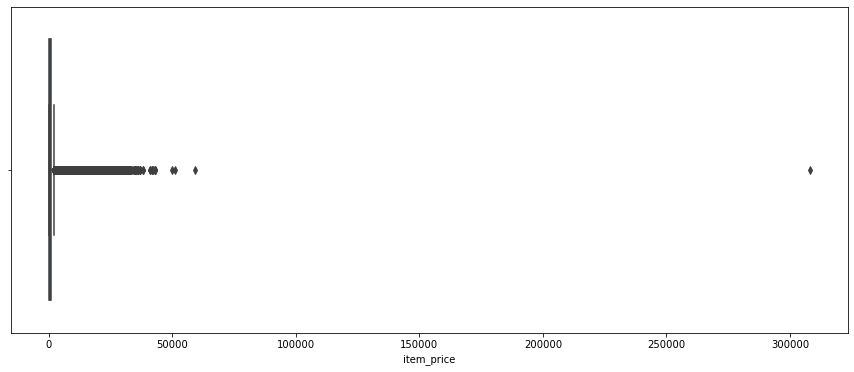

In [12]:
plt.figure(figsize=(15,6))
sns.boxplot(x=train_df.item_price)

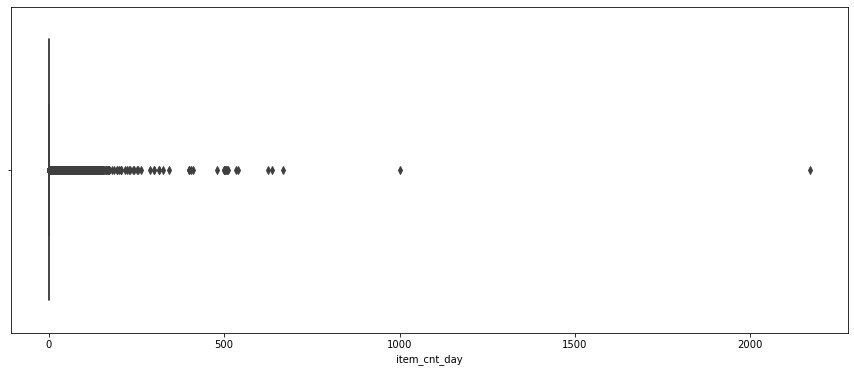

In [11]:
plt.figure(figsize=(15,6))
sns.boxplot(x=train_df.item_cnt_day)

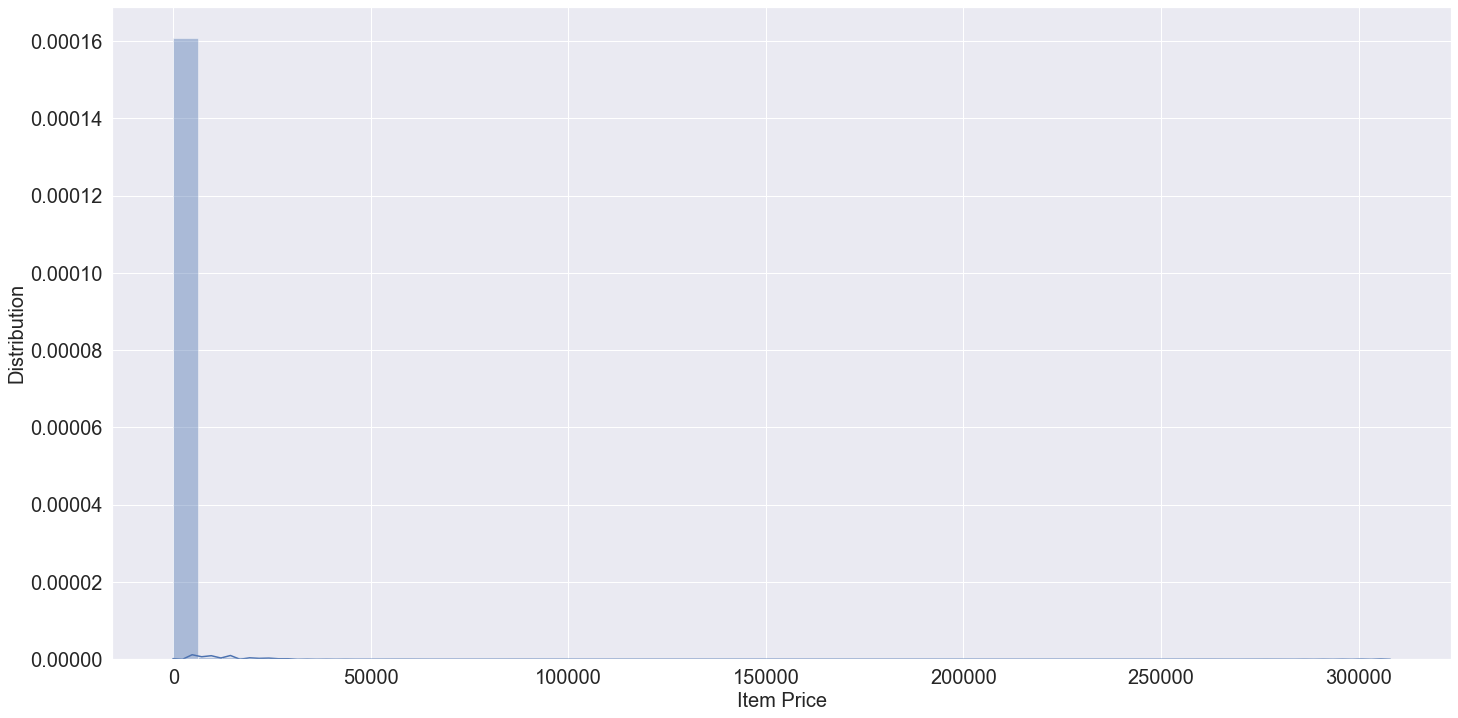

In [99]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train_df[train_df]['item_price'])
plt.xlabel('Item Price', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

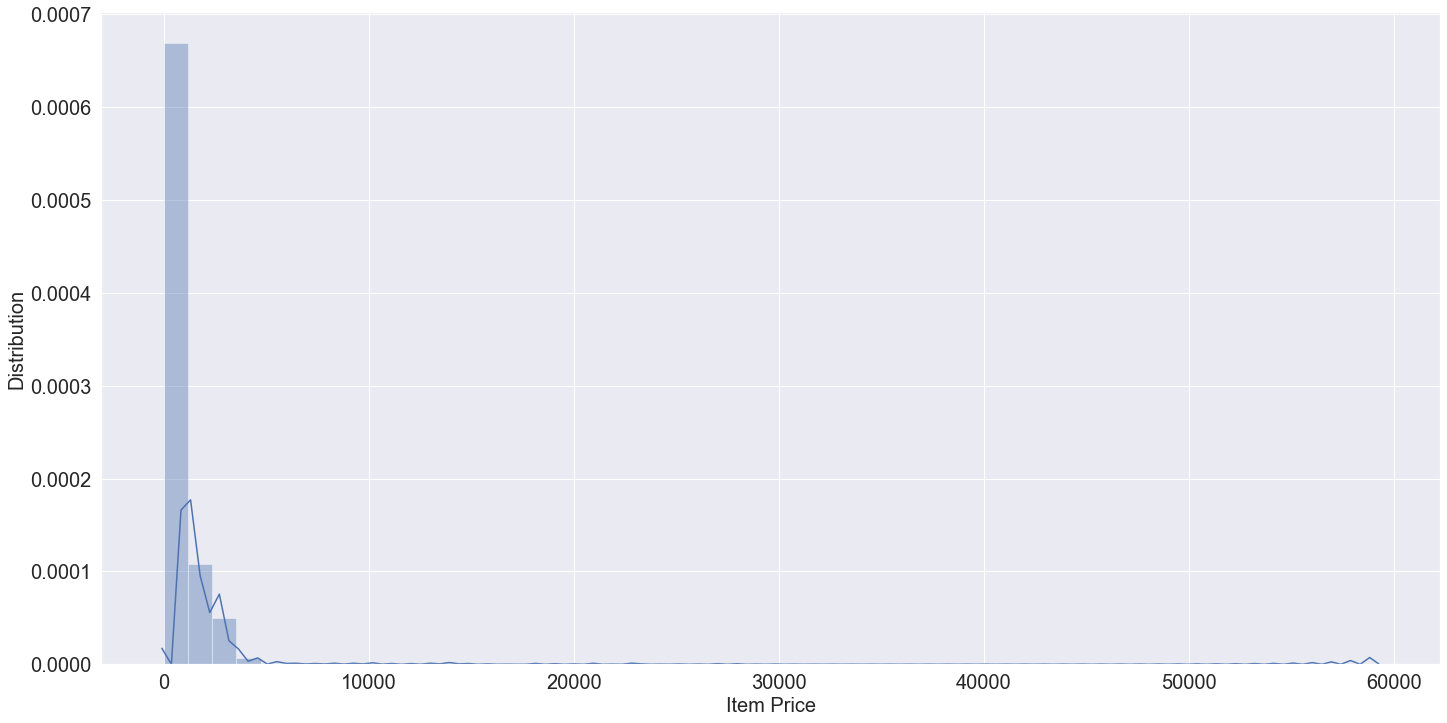

In [106]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train_df[train_df.item_price < 300000]['item_price'])
plt.xlabel('Item Price', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

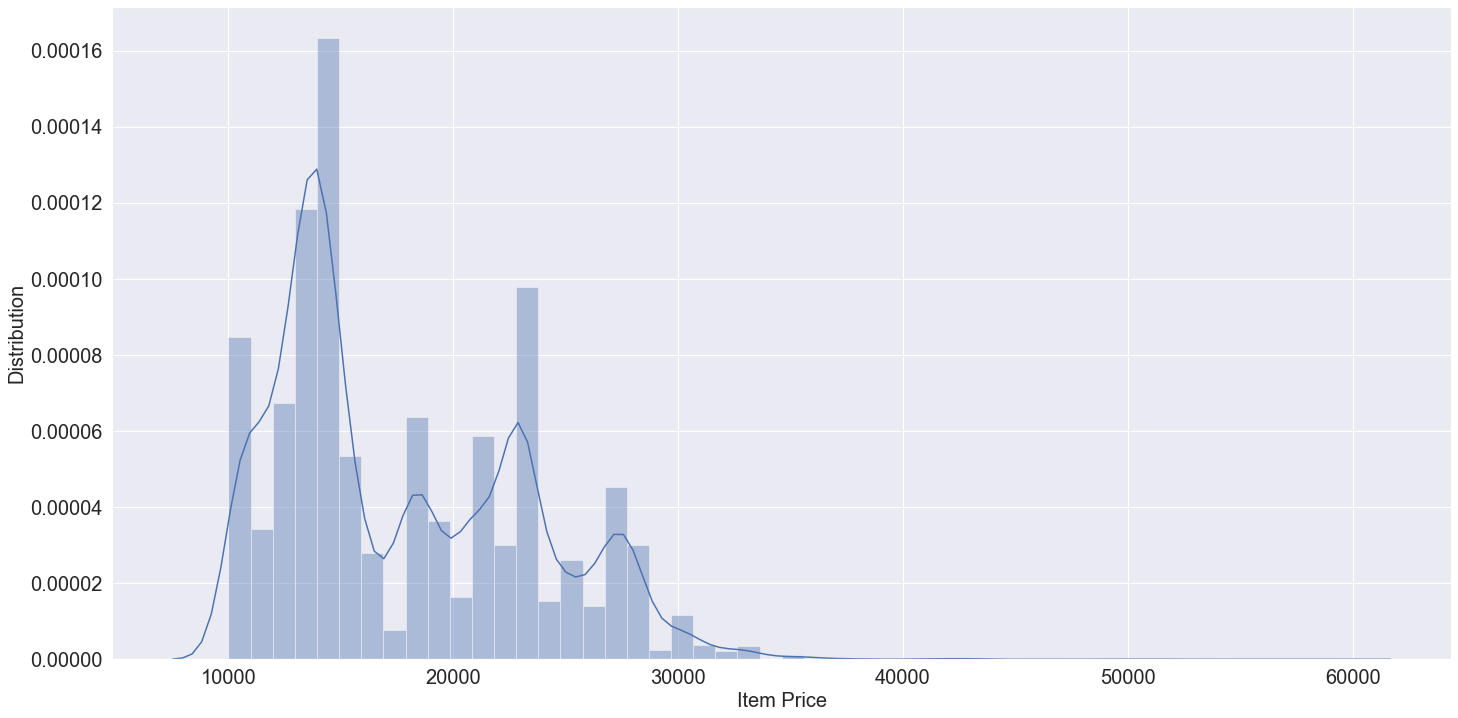

In [107]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train_df[(train_df.item_price < 300000) & (train_df.item_price > 10000)]['item_price'])
plt.xlabel('Item Price', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

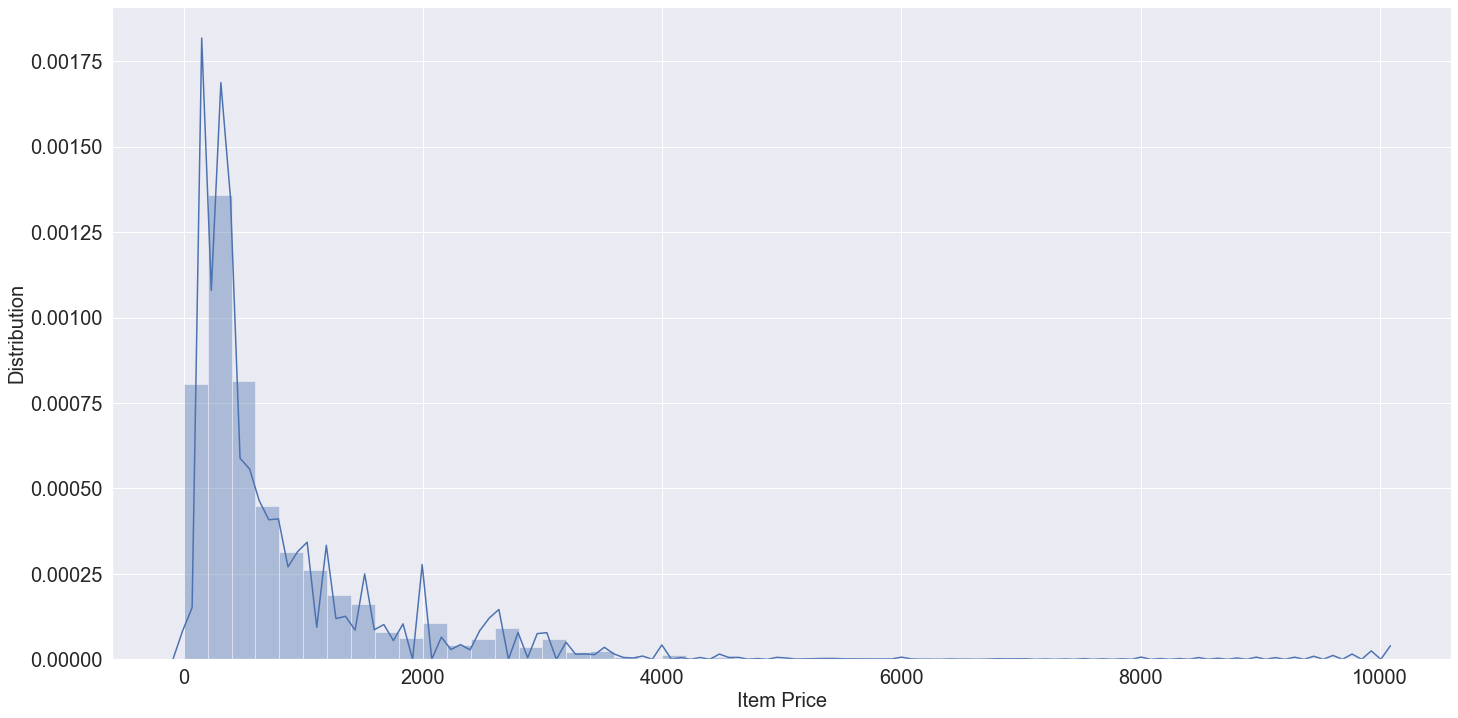

In [108]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train_df[(train_df.item_price < 10000)]['item_price'])
plt.xlabel('Item Price', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [330]:
train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_name_correct,item_category_name,category,city,month,year
0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Ярославль,1,2013
1,2013-01-02,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013
2,2013-01-03,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013
3,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013
4,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-22,33,55,13093,250.0,1.0,Цифровой склад 1С-Онлайн,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,карта оплаты windows: 250 рублей [цифровая вер...,Карты оплаты - Windows (Цифра),Карты оплаты,Цифровой,10,2015
2935845,2015-09-21,32,55,13091,1000.0,1.0,Цифровой склад 1С-Онлайн,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,карта оплаты windows: 1000 рублей [цифровая ве...,Карты оплаты - Windows (Цифра),Карты оплаты,Цифровой,9,2015
2935846,2015-09-16,32,55,13094,2500.0,1.0,Цифровой склад 1С-Онлайн,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,карта оплаты windows: 2500 рублей [цифровая ве...,Карты оплаты - Windows (Цифра),Карты оплаты,Цифровой,9,2015
2935847,2015-09-22,32,55,13094,2500.0,2.0,Цифровой склад 1С-Онлайн,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,карта оплаты windows: 2500 рублей [цифровая ве...,Карты оплаты - Windows (Цифра),Карты оплаты,Цифровой,9,2015


## Models

### Average of last 3 months 

In [570]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_name_correct,item_category_name,category,city,month,year
0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Ярославль,1,2013
1,2013-01-02,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013
2,2013-01-03,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013
3,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013
4,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,явление 2012 (bd),Кино - Blu-Ray,Кино,Москва,1,2013


In [571]:
baseline_train = train_df.groupby( ['date_block_num', 'shop_id', 'item_id', 'item_price', 'month', 'year', 'category', 'item_category_id', 'city'])['item_cnt_day'].sum().reset_index()
baseline_train = baseline_train.rename(columns={'item_cnt_day':'item_cnt_month'})

In [572]:
baseline_train.head()

,date_block_num,shop_id,item_id,item_price,month,year,category,item_category_id,city,item_cnt_month
0,0,2,27,2499.0,1,2013,Игры,19,Адыгея,1.0
1,0,2,33,499.0,1,2013,Кино,37,Адыгея,1.0
2,0,2,317,299.0,1,2013,Книги,45,Адыгея,1.0
3,0,2,438,299.0,1,2013,Книги,45,Адыгея,1.0
4,0,2,471,399.0,1,2013,Книги,49,Адыгея,2.0


In [584]:
x = baseline_train[baseline_train.date_block_num == baseline_train['date_block_num'].max()].head(1)

In [624]:
(train_df.item_price > 1000).mean()

0.22564273571290622

In [625]:
train_df[train_df.item_price > 1000].count()

date                  662453
date_block_num        662453
shop_id               662453
item_id               662453
item_price            662453
item_cnt_day          662453
shop_name             662453
item_name             662453
item_category_id      662453
item_name_correct     662453
item_category_name    662453
category              662453
city                  662453
month                 662453
year                  662453
dtype: int64

In [581]:
def get_first_day_of_month(year, month):
    return datetime.datetime(year=year, month=month, day=1).strftime("%Y-%m-%d")

In [580]:
def get_last_day_of_month(year, month):
    day = calendar.monthrange(year, month)[1]
    return datetime.datetime(year=year, month=month, day=day).strftime("%Y-%m-%d")

In [592]:
def generate_all_ids_dataset(start_year, start_month, end_year, end_month):
    start_date = get_first_day_of_month(start_year, start_month)
    end_date = get_last_day_of_month(end_year, end_month)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    all_dates_df = pd.DataFrame({'date':all_dates})
    item_dates = items.merge(all_dates_df, how='cross')[['item_id', 'date']]
    item_ids = items[[ 'item_id']].drop_duplicates()
    item_id_dataset = item_ids.merge(all_dates_df, how='cross')
    item_id_dataset['month'] = item_id_dataset['date'].apply(lambda x: x.month) 
    item_id_dataset['year'] = item_id_dataset['date'].apply(lambda x: x.year) 
    item_id_dataset = item_id_dataset.drop(columns = ['date'])
    return item_id_dataset

In [588]:
def get_last_x_month_df(df, num_of_months):
    max_month = df['date_block_num'].max()
    max_month_used = max_month + 1 - num_of_months
    
    df_last_x_month = df[df.date_block_num >= max_month_used]
    df_last_x_month = df_last_x_month.groupby(['item_id', 'month', 'year']).agg({'item_cnt_month': 'sum'}).reset_index()
    
    max_month_row = df[df.date_block_num == max_month].head(1)
    min_month_row = df[df.date_block_num == max_month_used].head(1)
    start_month, start_year = min_month_row.month.values[0], min_month_row.year.values[0]
    end_month, end_year = max_month_row.month.values[0], max_month_row.year.values[0]
    
    item_id_dataset_reduced = generate_all_ids_dataset(start_year, start_month, end_year, end_month)
    full_last_x_df = item_id_dataset_reduced.merge(df_last_x_month, how='left', on=['item_id', 'month', 'year'])
    full_last_x_df = full_last_x_df.fillna(-100)
    return full_last_x_df

In [606]:
def get_avg_prediction(df):
    avg_results = df.groupby(['item_id', 'shop_id']).agg({'item_cnt_month':'mean'}).reset_index()
    avg_results['item_cnt_month'] = avg_results['item_cnt_month'].apply(lambda x: float(int(x + 0.5)))
    return avg_results

In [441]:
# def predict_average(df, period = 3):
#     max_month = 34 - period
#     df_last_3_month = df[df.date_block_num >= max_month]
#     df_last_3_month = df_last_3_month.groupby(['item_id', 'month', 'year']).agg({'item_cnt_month': 'sum'}).reset_index()
#     item_id_dataset_reduced = item_id_dataset[(item_id_dataset.year == 2015) & (item_id_dataset.month >=(11 - period))]
#     full_last_3_df = item_id_dataset_reduced.merge(df_last_3_month, how='left', on=['item_id', 'month', 'year'])
#     full_last_3_df = full_last_3_df.fillna(0)
#     avg_results = full_last_3_df.groupby('item_id').agg({'item_cnt_month':'mean'}).reset_index()
#     avg_results['item_cnt_month'] = avg_results['item_cnt_month'].apply(lambda x: float(int(x + 0.5)))
#     return avg_results

In [405]:
def total_average(df):
    df_average = df.groupby(['item_id', 'month', 'year']).agg({'item_cnt_month': 'sum'}).reset_index()
    full_df = item_id_dataset.merge(df_average, how='left', on=['item_id', 'month', 'year'])
    full_df = full_df.fillna(0)
    avg_results = full_df.groupby('item_id').agg({'item_cnt_month':'mean'}).reset_index()
    avg_results['item_cnt_month'] = avg_results['item_cnt_month'].apply(lambda x: float(int(x + 0.5)))
    return avg_results

In [590]:
baseline_train

,date_block_num,shop_id,item_id,item_price,month,year,category,item_category_id,city,item_cnt_month
0,0,2,27,2499.0,1,2013,Игры,19,Адыгея,1.0
1,0,2,33,499.0,1,2013,Кино,37,Адыгея,1.0
2,0,2,317,299.0,1,2013,Книги,45,Адыгея,1.0
3,0,2,438,299.0,1,2013,Книги,45,Адыгея,1.0
4,0,2,471,399.0,1,2013,Книги,49,Адыгея,2.0
...,...,...,...,...,...,...,...,...,...,...
1739017,33,59,22087,119.0,10,2015,Элементы питания,83,Ярославль,6.0
1739018,33,59,22088,119.0,10,2015,Элементы питания,83,Ярославль,2.0
1739019,33,59,22091,179.0,10,2015,Элементы питания,83,Ярославль,1.0
1739020,33,59,22100,629.0,10,2015,Книги,42,Ярославль,1.0


In [593]:
last_3_month = get_last_x_month_df(baseline_train, 3)

In [595]:
last_3_month.tail(10)

,item_id,month,year,item_cnt_month
66500,22166,10,2015,11.0
66501,22167,8,2015,29.0
66502,22167,9,2015,21.0
66503,22167,10,2015,37.0
66504,22168,8,2015,-100.0
66505,22168,9,2015,-100.0
66506,22168,10,2015,-100.0
66507,22169,8,2015,-100.0
66508,22169,9,2015,-100.0
66509,22169,10,2015,-100.0


In [470]:
item_categories = baseline_train[['category', 'item_id']].drop_duplicates()

In [596]:
last_3_month_with_category = last_3_month.merge(item_categories, on='item_id')

In [597]:
last_3_month_with_category

,item_id,month,year,item_cnt_month,category
0,0,8,2015,-100.0,Кино
1,0,9,2015,-100.0,Кино
2,0,10,2015,-100.0,Кино
3,1,8,2015,-100.0,Программы
4,1,9,2015,-100.0,Программы
...,...,...,...,...,...
65416,22168,9,2015,-100.0,Подарки
65417,22168,10,2015,-100.0,Подарки
65418,22169,8,2015,-100.0,Подарки
65419,22169,9,2015,-100.0,Подарки


In [600]:
last_3_month_with_category[last_3_month_with_category.item_cnt_month == -100]

,item_id,month,year,item_cnt_month,category
0,0,8,2015,-100.0,Кино
1,0,9,2015,-100.0,Кино
2,0,10,2015,-100.0,Кино
3,1,8,2015,-100.0,Программы
4,1,9,2015,-100.0,Программы
...,...,...,...,...,...
65416,22168,9,2015,-100.0,Подарки
65417,22168,10,2015,-100.0,Подарки
65418,22169,8,2015,-100.0,Подарки
65419,22169,9,2015,-100.0,Подарки


In [601]:
agg_by_category = last_3_month_with_category[last_3_month_with_category.item_cnt_month > -100].groupby(['category', 'month', 'year']).agg({'item_cnt_month':'mean'}).reset_index()

In [602]:
last_3_month_with_category = last_3_month_with_category.merge(agg_by_category, on=['category', 'month', 'year'], suffixes=['_real', '_avg_cat'])

In [603]:
last_3_month_with_category['item_cnt_month_real'] = last_3_month_with_category.apply(lambda x: x['item_cnt_month_real'] if x['item_cnt_month_real'] >=0 else x['item_cnt_month_avg_cat'], axis = 1)

In [604]:
last_3_month_with_category.head(10)

,item_id,month,year,item_cnt_month_real,category,item_cnt_month_avg_cat
0,0,8,2015,9.052414,Кино,9.052414
1,2,8,2015,9.052414,Кино,9.052414
2,3,8,2015,9.052414,Кино,9.052414
3,4,8,2015,9.052414,Кино,9.052414
4,5,8,2015,9.052414,Кино,9.052414
5,6,8,2015,9.052414,Кино,9.052414
6,7,8,2015,9.052414,Кино,9.052414
7,8,8,2015,9.052414,Кино,9.052414
8,9,8,2015,9.052414,Кино,9.052414
9,10,8,2015,9.052414,Кино,9.052414


In [607]:
baseline_predict = get_avg_prediction(baseline_train)

In [608]:
baseline_predict

,item_id,shop_id,item_cnt_month
0,0,54,1.0
1,1,55,1.0
2,2,54,1.0
3,3,54,1.0
4,4,54,1.0
...,...,...,...
418904,22168,12,1.0
418905,22168,16,1.0
418906,22168,42,1.0
418907,22168,43,1.0


In [620]:
test_df[(test_df.item_id == 22168) & (test_df.shop_id == 12)]

,ID,shop_id,item_id,shop_name,item_name,item_category_id,item_name_correct,item_category_name,category,city


In [617]:
baseline_predict_with_id = baseline_predict.merge(test_df[['item_id', 'shop_id', 'ID']], on=['item_id', 'shop_id'], how='left')

In [616]:
baseline_predict_with_id

,item_id,shop_id,item_cnt_month,ID
0,0,54,1.0,NaN
1,1,55,1.0,NaN
2,2,54,1.0,NaN
3,3,54,1.0,NaN
4,4,54,1.0,NaN
...,...,...,...,...
418904,22168,12,1.0,NaN
418905,22168,16,1.0,NaN
418906,22168,42,1.0,NaN
418907,22168,43,1.0,NaN


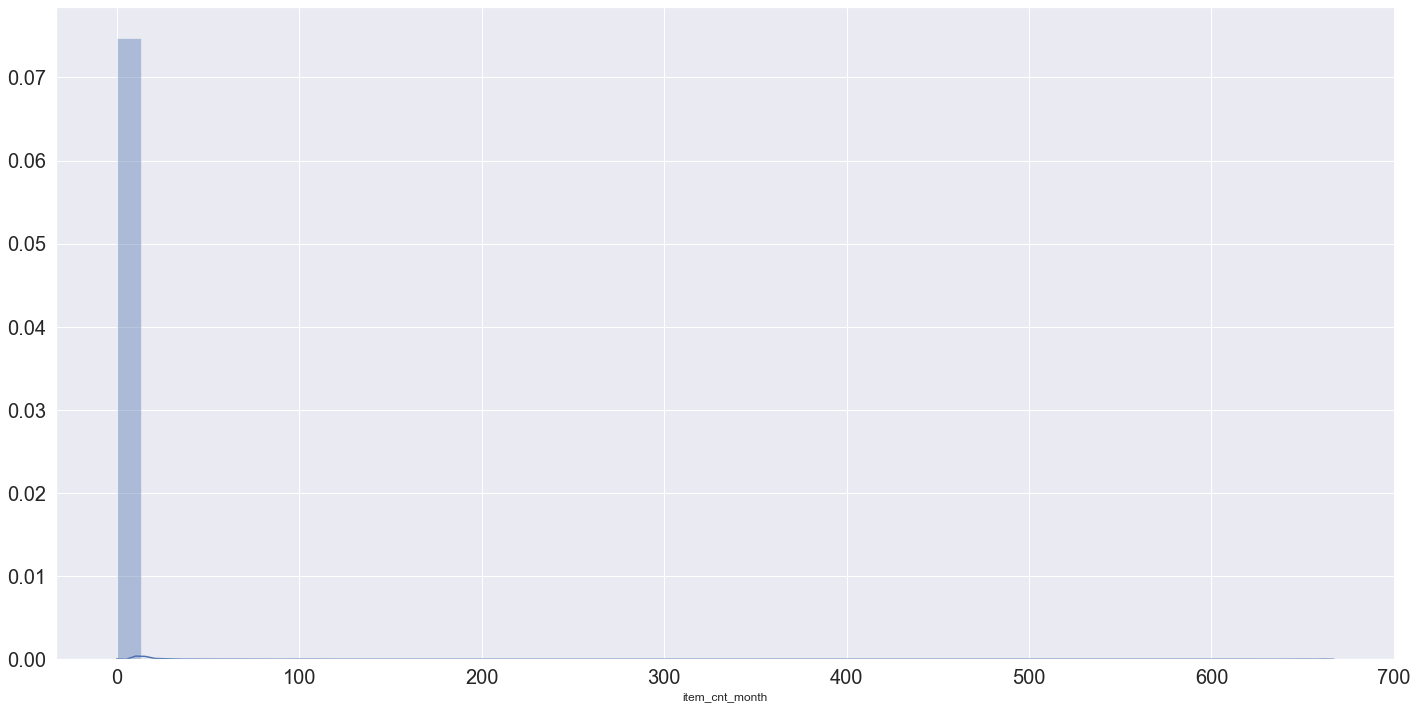

In [609]:
sns.distplot(baseline_predict['item_cnt_month'])

In [406]:
baseline_average = total_average(baseline_train)

In [482]:
last_3_month_with_category = last_3_month_with_category.rename(columns={'item_cnt_month_real':'item_cnt_month'})

In [483]:
baseline_predict_with_correct_impute = get_avg_prediction(last_3_month_with_category)

In [484]:
baseline_predict_with_correct_impute

,item_id,item_cnt_month
0,0,9.0
1,1,7.0
2,2,9.0
3,3,9.0
4,4,9.0
...,...,...
21778,22165,17.0
21779,22166,9.0
21780,22167,29.0
21781,22168,13.0


In [509]:
def get_subm_merged(predicted_df):
    subm = pd.read_csv('sample_submission.csv.zip')
    predicted_df = predicted_df.rename(columns={'item_id': "ID"})
    res = subm.merge(predicted_df, on='ID', how='left')
    res = res.drop(columns=['item_cnt_month_x'])
    res = res.rename(columns={"item_cnt_month_y": "item_cnt_month"})
    res = res.fillna(-100)
    res = res.merge(item_categories, left_on='ID', right_on='item_id', how='left')
    return res

In [403]:
def save_prediction(predicted_df, filename):
    subm = pd.read_csv('sample_submission.csv.zip')
    predicted_df = predicted_df.rename(columns={'item_id': "ID"})
    res = subm.merge(predicted_df, on='ID', how='left')
    res = res.fillna(0)
    res = res.drop(columns=['item_cnt_month_x'])
    res = res.rename(columns={"item_cnt_month_y": "item_cnt_month"})
    res.to_csv(filename, index=False)

In [407]:
save_prediction(baseline_average, 'avg_total.csv')

In [393]:
subm = pd.read_csv('sample_submission.csv.zip')
subm = subm.rename(columns={"ID": "item_id"})

In [510]:
subm_avg = get_subm_merged(baseline_predict_with_correct_impute)
agg_by_category_subm = subm_avg[subm_avg.item_cnt_month > -100].groupby(['category']).agg({'item_cnt_month':'mean'}).reset_index()

In [522]:
subm_avg

,ID,item_cnt_month_real,category,item_id,item_cnt_month_avg_cat
0,0,9.0,Кино,0.0,9.036942
1,1,7.0,Программы,1.0,6.965608
2,2,9.0,Кино,2.0,9.036942
3,3,9.0,Кино,3.0,9.036942
4,4,9.0,Кино,4.0,9.036942
...,...,...,...,...,...
214195,214195,0.0,0,0.0,0.000000
214196,214196,0.0,0,0.0,0.000000
214197,214197,0.0,0,0.0,0.000000
214198,214198,0.0,0,0.0,0.000000


In [512]:
train_df[train_df.item_id == 214195]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_name_correct,item_category_name,category,city,month,year


In [517]:
items[items.item_id == 214197].head()

,item_name,item_id,item_category_id,item_name_correct


In [518]:
subm_avg = subm_avg.merge(agg_by_category_subm, on=['category'], suffixes=['_real', '_avg_cat'], how='left')

In [520]:
subm_avg = subm_avg.fillna(0)

In [521]:
subm_avg['item_cnt_month_real'] = subm_avg.apply(lambda x: x['item_cnt_month_real'] if x['item_cnt_month_real'] >=0 else x['item_cnt_month_avg_cat'], axis = 1)

In [523]:
subm_avg = subm_avg.rename(columns={"item_cnt_month_real": "item_cnt_month"})
subm_avg['item_cnt_month'] = subm_avg['item_cnt_month'].apply(lambda x: float(int(x + 0.5)))
subm_avg = subm_avg[['ID', 'item_cnt_month']]

In [524]:
subm_avg.to_csv('subm1.csv', index=False)

In [397]:
res = subm.merge(baseline_predict, on='item_id')
res = res.fillna(0)

In [121]:
X = baseline_train.drop(columns=['item_cnt_month']).sort_values(by="date_block_num")
y = baseline_train['item_cnt_month']
lr = LinearRegression()
tscv = TimeSeriesSplit(5)
cv_score = cross_val_score(lr, X, y, cv=tscv, scoring='r2')

In [122]:
cv_score

array([-8.38220480e-04, -2.04337538e-04, -3.70490292e-03, -8.76351175e-05,
       -1.11017502e-03])

In [123]:
X

,date_block_num,shop_id,item_id,item_price
0,0,0,32,221.0
44740,0,37,18822,149.0
44741,0,37,18826,349.0
44742,0,37,18845,299.0
44743,0,37,18846,299.0
...,...,...,...,...
1716882,33,24,6740,999.0
1716881,33,24,6738,999.0
1716880,33,24,6710,599.0
1716910,33,24,7499,399.0
